# AB InBev Beer Challenge - preprocessing and EDA

## Configuración y funciones a utilizar

In [1]:
from utils import *
from functools import reduce

## Extracción de los datos

In [2]:
# Read the csv files of the atributes
file_path_atributes = "../data/inputs/raw/atributos.csv"
atributes = read_csv_with_lowercase_columns(file_path_atributes)
categorical = ["bussinesssegment","concentracion","nse","segmentounico","canal"]
numerical = ["totalvolumen","skudistintospromediosxorden","skudistintostotales"]
# Read the csv files of the transactions
file_path_transactions = "../data/inputs/raw/transacciones.csv"
transactions = read_csv_with_lowercase_columns(file_path_transactions)
# Display the first rows of the DataFrame of the transactions
print(transactions.shape)
transactions.head()

(280828, 6)


,account_id,sku_id,invoice_date,order_id,items_phys_cases
i64,i64,i64,i64,str,f64
0,430606,7038,20220729,"""512-3880249-0""",100.0
1,323267,14933,20220729,"""512-3882307-0""",1.0
2,357825,21971,20220723,"""512-3852880-0""",8.0
3,444926,7038,20220805,"""512-3913163-0""",20.0
4,450771,7030,20220816,"""512-3957000-0""",5.0


In [3]:
# Display the first rows of the DataFrame of the atribues
print(atributes.shape)
atributes.head()

(4400, 10)


,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,nse,segmentounico,canal
i64,i64,str,f64,f64,i64,str,str,str,str
10,175519,"""HighUsage""",5.18752,4.1,16,"""Medio""","""Bajo""","""4.Activos""","""Kioscos/Maxikioscos"""
13,28533,"""HighUsage""",4.76866,3.9211,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
19,32182,"""PowerUsage""",5.9793,6.75,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
20,327976,"""MinimalUsage""",6.02852,3.5833,14,"""Alto""","""Medio""","""4.Activos""","""COMIDA"""
24,354640,"""PowerUsage""",7.525,3.2,18,"""Bajo""","""S/D""","""4.Activos""","""Tradicional"""


## Preprocesamiento necesario para EDA

En las los atributos:

* Calidad de los datos:
    * Revisar valores nulos
    * Revisar valores fuera de rango
    * Cuantificar outliers

En las transacciones:

* Calidad de los datos:
    *Revisar valores nulos
    * Revisar valores fuera de rango
    * Cuantificar outliers

Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte con agrupación por cliente: Dado que estamos interesados en el comportamiento de compra de los clientes, vamos a agrupar los datos por account_id para analizar patrones de compra individuales.

* Crear dataset aparte con agrupación por item: Dado que también estamos interesados en el comportamiento de compra sobre los items, vamos a agrupar los datos por sku_id para analizar patrones de compra que se dan en general para los items.


### Datos de atributos de los clientes

#### Calidad de los datos:
* Revisar valores nulos 
* Revisar valores fuera de rango
* Cuantificar outliers

##### **Análsis de valores nulos**

* Al notar que las distribuciones del dataset de no nulos es distinta, analizamos la relación entre las variables categóricas en cuestion: nse, concentracion, segmento unico y canal donde validamos que no son independientes entre si. Dado esto y que por su definición los efectos del NSE en latinoamerica normalmente están contenidos la cantidad de comercios en la zona debido a la segregación de las ciudades, es que hemos decidido eliminar la columna del NSE para no alterar las distribuciones de las métricas de interés.

* Con respecto al resto de los valores nulos, sumados corresponden al 8.8% de los datos y podemos notar que no generan un cambio en la distribución de las métricas de interés cuando eliminamos sus filas. Sin embargo, al analizar quienes son los clientes que hay en los valores nulos, podemos notar que solo un 20% es de bajo poder de compra y que dentro de los que tienen poco uso de la plataforma, hay varios con un potencial bueno de compra para el negocio por lo que se decide no hacer la eliminación de clientes.

* Un proxy de la concentración deberían ser las métricas de venta y las otras categorías, por lo que imputamos los valores faltantes de las variables categóricas concentración, segmento único y canal utilizando dichas variables explicativas

In [4]:
# Reemplazar "S/D" por nulos en las columnas "nse" y "concentración"
atributes = replace_sd_with_null(atributes, ["nse", "concentracion"])
# Revisar valores nulos en el DataFrame
null_values_df = check_null_values(atributes)
# Mostrar el resultado
print(null_values_df)
atributes[numerical].describe()

shape: (10, 3)
┌─────────────────────────────┬────────────┬─────────────────┐
│ column                      ┆ null_count ┆ null_percentage │
│ ---                         ┆ ---        ┆ ---             │
│ str                         ┆ u32        ┆ f64             │
╞═════════════════════════════╪════════════╪═════════════════╡
│                             ┆ 0          ┆ 0.0             │
│ poc                         ┆ 0          ┆ 0.0             │
│ bussinesssegment            ┆ 0          ┆ 0.0             │
│ totalvolumen                ┆ 0          ┆ 0.0             │
│ skudistintospromediosxorden ┆ 0          ┆ 0.0             │
│ skudistintostotales         ┆ 0          ┆ 0.0             │
│ concentracion               ┆ 326        ┆ 7.409091        │
│ nse                         ┆ 1023       ┆ 23.25           │
│ segmentounico               ┆ 75         ┆ 1.704545        │
│ canal                       ┆ 14         ┆ 0.318182        │
└─────────────────────────────┴─────────

statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",4400.0,4400.0,4400.0
"""null_count""",0.0,0.0,0.0
"""mean""",22.272537,5.911031,27.832727
"""std""",106.642437,3.227491,21.640289
"""min""",0.02124,0.7027,1.0
"""25%""",2.12124,3.6667,12.0
"""50%""",5.6011,5.1429,22.0
"""75%""",13.95536,7.3542,38.0
"""max""",4274.44416,33.0,157.0


##### NSE

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 1075.0       ┆ 1075.0                      ┆ 1075.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 26.813149    ┆ 6.182723                    ┆ 25.525581           │
│ std        ┆ 114.105641   ┆ 3.501458                    ┆ 19.875404           │
│ min        ┆ 0.02508      ┆ 0.75                        ┆ 1.0                 │
│ 25%        ┆ 1.82192      ┆ 3.8333                      ┆ 11.0                │
│ 50%        ┆ 4.8178       ┆ 5.5                         ┆ 20.0                │
│ 

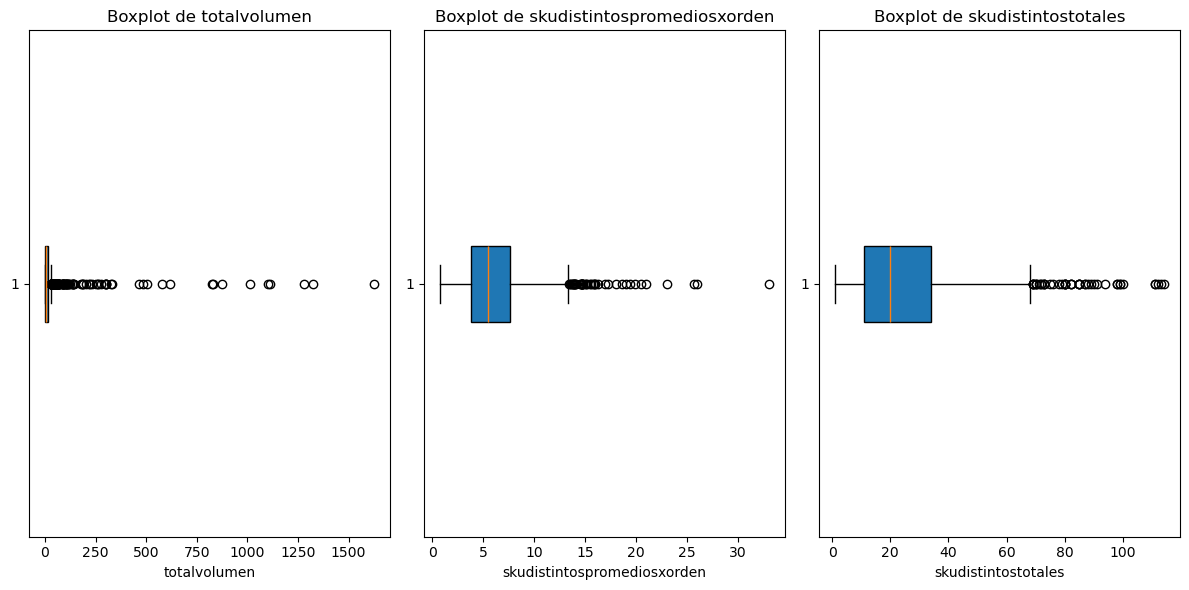

In [5]:
# filtramos los nulos
df_with_nulls = filter_rows_with_nulls(atributes)
# Mostrar las características de los valores nulos
print(df_with_nulls[numerical].describe())
plot_boxplots(df_with_nulls,numerical)

In [6]:
chi2_matrix(chi2_test, atributes, categorical, confidence_level=0.99)

,bussinesssegment,concentracion,nse,segmentounico,canal
bussinesssegment,False,True,True,True,True
concentracion,True,False,True,True,True
nse,True,True,False,True,True
segmentounico,True,True,True,False,True
canal,True,True,True,True,False


In [7]:
categorical = ["bussinesssegment","concentracion","segmentounico","canal"]
# Eliminar la columna "nse" del DataFrame
atributes = atributes.drop("nse")
print(check_null_values(atributes))
atributes.shape

shape: (9, 3)
┌─────────────────────────────┬────────────┬─────────────────┐
│ column                      ┆ null_count ┆ null_percentage │
│ ---                         ┆ ---        ┆ ---             │
│ str                         ┆ u32        ┆ f64             │
╞═════════════════════════════╪════════════╪═════════════════╡
│                             ┆ 0          ┆ 0.0             │
│ poc                         ┆ 0          ┆ 0.0             │
│ bussinesssegment            ┆ 0          ┆ 0.0             │
│ totalvolumen                ┆ 0          ┆ 0.0             │
│ skudistintospromediosxorden ┆ 0          ┆ 0.0             │
│ skudistintostotales         ┆ 0          ┆ 0.0             │
│ concentracion               ┆ 326        ┆ 7.409091        │
│ segmentounico               ┆ 75         ┆ 1.704545        │
│ canal                       ┆ 14         ┆ 0.318182        │
└─────────────────────────────┴────────────┴─────────────────┘


(4400, 9)

##### Imputación de valores nulos

* Para las variables concentración, canal y segmento único haremos imputación de datos

* Usamo un modelo de regresión logística ordenada para entender la significancia estádistica e impacto de las variables numéricas en la cateogoría target

* Luego, usamos las variables numéricas relevantes y las otras variables categóricas para imputar los valores faltantes de concentración, segmento único y canal utilizado, usando el algoritmo de Random Forest. El F1-score en datos de test del modelo que se usa para imputar da 0.53, 0.61 y 0.57, respectivamente. Debido a la baja performance del modelo que usamos para imputar y como mecanimos de validación, a medida que vamos haciendo las predicciones, vamos verificando que las distribuciones por categoría de las variables numéricas no cambien de forma significativa (nos fijamos en los percentiles, no en los promedios). Salvo casos aislados como el canal "Otros-ref", en general no hubo cambios de distibución importantes. 

In [8]:
count_distinct_grouped_by(df_with_nulls, y_column="poc", x_columns=["segmentounico","bussinesssegment"],z_columns=["segmentounico","bussinesssegment"])

segmentounico,bussinesssegment,poc_distinct_count,total_first_column,poc_percentage
str,str,u32,u32,f64
"""5.Select""","""PowerUsage""",89,144,61.805556
"""5.Select""","""HighUsage""",55,144,38.194444
"""4.Activos""","""PowerUsage""",124,400,31.0
"""4.Activos""","""MinimalUsage""",46,400,11.5
"""4.Activos""","""MediumUsage""",111,400,27.75
"""4.Activos""","""HighUsage""",119,400,29.75
"""3.Potenciales""","""PowerUsage""",2,34,5.882353
"""3.Potenciales""","""MinimalUsage""",14,34,41.176471
"""3.Potenciales""","""MediumUsage""",13,34,38.235294


In [9]:
# Filter the original DataFrame to keep only rows without null values
df_without_nulls = filter_rows_without_nulls(atributes)
print(df_without_nulls[numerical].describe())

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4011.0       ┆ 4011.0                      ┆ 4011.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 21.644617    ┆ 5.81108                     ┆ 28.328596           │
│ std        ┆ 104.005686   ┆ 3.109883                    ┆ 21.90761            │
│ min        ┆ 0.02124      ┆ 0.7027                      ┆ 1.0                 │
│ 25%        ┆ 2.20068      ┆ 3.625                       ┆ 12.0                │
│ 50%        ┆ 5.7351       ┆ 5.0                         ┆ 22.0                │
│ 

In [10]:
# Ejemplo de uso:
result = fit_ordered_logistic_regression(df_without_nulls, 'concentracion', numerical)
result.summary()

Optimization terminated successfully.
         Current function value: 0.781970
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                encoded   Log-Likelihood:                -3136.5
Model:                   OrderedModel   AIC:                             6283.
Method:            Maximum Likelihood   BIC:                             6314.
Date:                Tue, 20 Aug 2024                                         
Time:                        12:21:50                                         
No. Observations:                4011                                         
Df Residuals:                    4006                                         
Df Model:                           3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
totalvolumen                    0.0006      0.000      1.486      0.137      -0.000       0.001
skudistintospromediosxorden    -0.1246      0.014     -8.633      0.000      -0.153      -0.096
skudistintostotales            -0.0023      0.002     -1.156      0.248      -0.006       0.002
0/1                            -0.6794      0.072     -9.472      0.000      -0.820      -0.539
1/2                            -2.1040      0.091    -23.086      0.000      -2.283      -1.925
===============================================================================================
"""

In [11]:
# Ejemplo de uso:
atributes_updated ,cf_report, accuracy, cross_val_mean= fill_missing_values(atributes, 'concentracion', ['skudistintostotales'], ['bussinesssegment', 'segmentounico', 'canal'])
# Evaluar el modelo
print(cf_report)
print("Accuracy:", accuracy)
print("Cross-validation mean score:", cross_val_mean)
# Mostrar las primeras filas del DataFrame actualizado
check_null_values(atributes_updated)

              precision    recall  f1-score   support

        Alto       0.58      0.55      0.57       427
        Bajo       0.09      0.03      0.05        29
       Medio       0.49      0.55      0.52       359

    accuracy                           0.53       815
   macro avg       0.39      0.38      0.38       815
weighted avg       0.53      0.53      0.53       815

Accuracy: 0.5325153374233129
Cross-validation mean score: 0.5256156173136185


column,null_count,null_percentage
str,u32,f64
"""column_0""",0,0.0
"""poc""",0,0.0
"""bussinesssegment""",0,0.0
"""totalvolumen""",0,0.0
"""skudistintospromediosxorden""",0,0.0
"""skudistintostotales""",0,0.0
"""concentracion""",0,0.0
"""segmentounico""",75,1.704545
"""canal""",14,0.318182


In [12]:
print(count_distinct_grouped_by(atributes_updated, y_column="poc", x_columns=["concentracion"],z_columns=["poc_percentage"]))
count_distinct_grouped_by(df_without_nulls, y_column="poc", x_columns=["concentracion"],z_columns=["poc_percentage"])

shape: (3, 4)
┌───────────────┬────────────────────┬────────────────────┬────────────────┐
│ concentracion ┆ poc_distinct_count ┆ total_first_column ┆ poc_percentage │
│ ---           ┆ ---                ┆ ---                ┆ ---            │
│ str           ┆ u32                ┆ i32                ┆ f64            │
╞═══════════════╪════════════════════╪════════════════════╪════════════════╡
│ Alto          ┆ 2319               ┆ 4400               ┆ 52.704545      │
│ Medio         ┆ 1954               ┆ 4400               ┆ 44.409091      │
│ Bajo          ┆ 127                ┆ 4400               ┆ 2.886364       │
└───────────────┴────────────────────┴────────────────────┴────────────────┘


concentracion,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Alto""",2089,4011,52.081775
"""Medio""",1805,4011,45.001247
"""Bajo""",117,4011,2.916978


In [13]:
group_and_describe_with_percentiles(df_without_nulls, "concentracion", numerical).sort('concentracion')

concentracion,count,totalvolumen_mean,skudistintospromediosxorden_mean,skudistintostotales_mean,totalvolumen_median,skudistintospromediosxorden_median,skudistintostotales_median,totalvolumen_std_dev,skudistintospromediosxorden_std_dev,skudistintostotales_std_dev,totalvolumen_p25,totalvolumen_p50,totalvolumen_p75,skudistintospromediosxorden_p25,skudistintospromediosxorden_p50,skudistintospromediosxorden_p75,skudistintostotales_p25,skudistintostotales_p50,skudistintostotales_p75
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Alto""",2089,18.892961,6.402027,31.218765,5.85912,5.6818,25.0,71.696408,3.337813,23.44018,2.12358,5.85912,14.87472,4.0,5.6818,8.0,13.0,25.0,43.0
"""Bajo""",117,20.168322,4.902802,22.777778,5.81728,4.2857,14.0,73.472624,2.382811,21.367116,2.158,5.81728,13.63538,3.125,4.2857,6.3571,10.0,14.0,31.0
"""Medio""",1805,24.924913,5.186029,25.34349,5.6224,4.5556,20.0,133.1482,2.718291,19.518015,2.29222,5.6224,13.56136,3.3333,4.5556,6.3182,11.0,20.0,34.0


In [14]:
group_and_describe_with_percentiles(atributes_updated, "concentracion", numerical).sort('concentracion')

concentracion,count,totalvolumen_mean,skudistintospromediosxorden_mean,skudistintostotales_mean,totalvolumen_median,skudistintospromediosxorden_median,skudistintostotales_median,totalvolumen_std_dev,skudistintospromediosxorden_std_dev,skudistintostotales_std_dev,totalvolumen_p25,totalvolumen_p50,totalvolumen_p75,skudistintospromediosxorden_p25,skudistintospromediosxorden_p50,skudistintospromediosxorden_p75,skudistintostotales_p25,skudistintostotales_p50,skudistintostotales_p75
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Alto""",2319,19.318276,6.483111,30.451488,5.64996,5.75,24.0,74.823073,3.461682,23.165108,2.05066,5.64996,14.39806,4.0,5.75,8.125,13.0,24.0,43.0
"""Bajo""",127,19.218336,5.156998,23.330709,6.01514,4.4211,15.0,70.596346,2.633552,22.222559,2.32184,6.01514,13.63538,3.1818,4.4211,6.65,10.0,15.0,32.0
"""Medio""",1954,25.977151,5.281097,25.0174,5.53681,4.61065,20.0,136.47339,2.823124,19.200367,2.24466,5.537,13.3329,3.3333,4.6111,6.4211,11.0,20.0,33.0


In [15]:
# Ejemplo de uso:
result = fit_ordered_logistic_regression(df_without_nulls, 'segmentounico', numerical)
result.summary()

Optimization terminated successfully.
         Current function value: 1.177408
         Iterations: 27
         Function evaluations: 32
         Gradient evaluations: 32


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                encoded   Log-Likelihood:                -4722.6
Model:                   OrderedModel   AIC:                             9459.
Method:            Maximum Likelihood   BIC:                             9503.
Date:                Tue, 20 Aug 2024                                         
Time:                        12:21:51                                         
No. Observations:                4011                                         
Df Residuals:                    4004                                         
Df Model:                           3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
totalvolumen                    0.0044      0.001      6.374      0.000       0.003       0.006
skudistintospromediosxorden    -0.1253      0.013     -9.892      0.000      -0.150      -0.100
skudistintostotales             0.0690      0.002     29.609      0.000       0.064       0.074
0/1                            -0.5033      0.068     -7.402      0.000      -0.637      -0.370
1/2                             0.0757      0.034      2.199      0.028       0.008       0.143
2/3                            -1.9356      0.094    -20.528      0.000      -2.120      -1.751
3/4                             1.0603      0.023     46.715      0.000       1.016       1.105
===============================================================================================
"""

In [16]:
# Ejemplo de uso:
atributes_updated ,cf_report, accuracy, cross_val_mean= fill_missing_values(atributes_updated, 'segmentounico', ['skudistintostotales','skudistintospromediosxorden','totalvolumen'], ['bussinesssegment', 'concentracion', 'canal'])
# Evaluar el modelo
print(cf_report)
print("Accuracy:", accuracy)
print("Cross-validation mean score:", cross_val_mean)
# Mostrar las primeras filas del DataFrame actualizado
check_null_values(atributes_updated)

               precision    recall  f1-score   support

  1.Inactivos       0.67      0.68      0.68       184
    2.Masivos       0.52      0.47      0.49       161
3.Potenciales       0.15      0.07      0.10        28
    4.Activos       0.61      0.70      0.65       367
     5.Select       0.71      0.56      0.62       125

     accuracy                           0.61       865
    macro avg       0.53      0.50      0.51       865
 weighted avg       0.61      0.61      0.61       865

Accuracy: 0.6127167630057804
Cross-validation mean score: 0.6190751445086705


column,null_count,null_percentage
str,u32,f64
"""column_0""",0,0.0
"""poc""",0,0.0
"""bussinesssegment""",0,0.0
"""totalvolumen""",0,0.0
"""skudistintospromediosxorden""",0,0.0
"""skudistintostotales""",0,0.0
"""concentracion""",0,0.0
"""segmentounico""",0,0.0
"""canal""",14,0.318182


In [17]:
print(count_distinct_grouped_by(df_without_nulls, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"]))
count_distinct_grouped_by(atributes_updated, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"])

shape: (5, 4)
┌───────────────┬────────────────────┬────────────────────┬────────────────┐
│ segmentounico ┆ poc_distinct_count ┆ total_first_column ┆ poc_percentage │
│ ---           ┆ ---                ┆ ---                ┆ ---            │
│ str           ┆ u32                ┆ i32                ┆ f64            │
╞═══════════════╪════════════════════╪════════════════════╪════════════════╡
│ 4.Activos     ┆ 1795               ┆ 4011               ┆ 44.751932      │
│ 1.Inactivos   ┆ 804                ┆ 4011               ┆ 20.044877      │
│ 2.Masivos     ┆ 708                ┆ 4011               ┆ 17.651458      │
│ 5.Select      ┆ 595                ┆ 4011               ┆ 14.834206      │
│ 3.Potenciales ┆ 109                ┆ 4011               ┆ 2.717527       │
└───────────────┴────────────────────┴────────────────────┴────────────────┘


segmentounico,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""4.Activos""",1934,4400,43.954545
"""1.Inactivos""",888,4400,20.181818
"""2.Masivos""",820,4400,18.636364
"""5.Select""",631,4400,14.340909
"""3.Potenciales""",127,4400,2.886364


In [18]:
group_and_describe_with_percentiles(df_without_nulls, "segmentounico", numerical)

segmentounico,count,totalvolumen_mean,skudistintospromediosxorden_mean,skudistintostotales_mean,totalvolumen_median,skudistintospromediosxorden_median,skudistintostotales_median,totalvolumen_std_dev,skudistintospromediosxorden_std_dev,skudistintostotales_std_dev,totalvolumen_p25,totalvolumen_p50,totalvolumen_p75,skudistintospromediosxorden_p25,skudistintospromediosxorden_p50,skudistintospromediosxorden_p75,skudistintostotales_p25,skudistintostotales_p50,skudistintostotales_p75
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""2.Masivos""",708,9.887889,5.629337,20.268362,4.48982,5.0,17.0,26.073617,3.049452,14.904553,1.90926,4.50136,8.09796,3.5,5.0,7.0714,9.0,17.0,28.0
"""5.Select""",595,68.149044,6.819948,50.621849,17.3101,6.049,47.0,238.30285,3.47014,26.189863,8.35212,17.3101,36.2526,4.3,6.049,8.9815,30.0,47.0,68.0
"""1.Inactivos""",804,2.4877,4.476126,12.120647,1.56015,4.0,11.0,3.664449,2.250522,8.163438,0.76258,1.56126,2.98188,3.0,4.0,5.3333,6.0,11.0,16.0
"""3.Potenciales""",109,45.953118,8.111235,35.449541,12.77314,7.5625,33.0,178.23672,3.311973,16.730703,7.95744,12.77314,28.38672,6.2,7.5625,9.75,24.0,33.0,44.0
"""4.Activos""",1795,17.971171,6.006615,30.945404,7.61332,5.2692,26.0,46.946604,3.086993,19.832192,3.30046,7.61332,15.79512,3.8333,5.2692,7.35,16.0,26.0,41.0


In [19]:
group_and_describe_with_percentiles(atributes_updated, "segmentounico", numerical)

segmentounico,count,totalvolumen_mean,skudistintospromediosxorden_mean,skudistintostotales_mean,totalvolumen_median,skudistintospromediosxorden_median,skudistintostotales_median,totalvolumen_std_dev,skudistintospromediosxorden_std_dev,skudistintostotales_std_dev,totalvolumen_p25,totalvolumen_p50,totalvolumen_p75,skudistintospromediosxorden_p25,skudistintospromediosxorden_p50,skudistintospromediosxorden_p75,skudistintostotales_p25,skudistintostotales_p50,skudistintostotales_p75
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""4.Activos""",1934,18.454372,6.101257,30.858842,7.619305,5.375,26.0,51.234575,3.15085,19.749052,3.2891,7.62095,15.78716,3.8667,5.375,7.5,16.0,26.0,41.0
"""3.Potenciales""",127,47.831755,8.503668,33.645669,11.991,7.7857,31.0,181.278135,3.670715,16.539768,6.4103,11.991,26.50188,6.3571,7.7857,10.8,23.0,31.0,43.0
"""2.Masivos""",820,9.583716,5.770779,19.503659,4.3525,5.04285,16.0,25.447217,3.214566,14.506745,1.77432,4.3571,7.7421,3.5769,5.05,7.2,9.0,16.0,27.0
"""5.Select""",631,73.224607,6.874734,50.275753,17.38062,6.0147,47.0,245.73012,3.671826,25.971597,8.34152,17.38062,37.51956,4.25,6.0147,8.9815,30.0,47.0,67.0
"""1.Inactivos""",888,2.444146,4.570655,12.154279,1.5582,4.125,11.0,3.545036,2.339944,8.181279,0.73942,1.55904,2.95866,3.0,4.125,5.6667,6.0,11.0,16.0


In [20]:
# Ejemplo de uso:
result = fit_ordered_logistic_regression(df_without_nulls, 'canal', numerical)
result.summary()

Optimization terminated successfully.
         Current function value: 1.174149
         Iterations: 33
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                encoded   Log-Likelihood:                -4709.5
Model:                   OrderedModel   AIC:                             9441.
Method:            Maximum Likelihood   BIC:                             9510.
Date:                Tue, 20 Aug 2024                                         
Time:                        12:21:53                                         
No. Observations:                4011                                         
Df Residuals:                    4000                                         
Df Model:                           3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
totalvolumen                   -0.0011      0.000     -2.964      0.003      -0.002      -0.000
skudistintospromediosxorden    -0.0476      0.013     -3.597      0.000      -0.073      -0.022
skudistintostotales             0.0013      0.002      0.630      0.529      -0.003       0.005
0/1                            -3.4076      0.100    -34.110      0.000      -3.603      -3.212
1/2                            -0.8398      0.108     -7.764      0.000      -1.052      -0.628
2/3                            -4.3778      0.578     -7.571      0.000      -5.511      -3.245
3/4                            -0.0096      0.052     -0.184      0.854      -0.111       0.092
4/5                            -2.0348      0.118    -17.292      0.000      -2.265      -1.804
5/6                             0.0301      0.034      0.897      0.370      -0.036       0.096
6/7                            -2.9886      0.145    -20.603      0.000      -3.273      -2.704
7/8                            -6.8497      1.004     -6.825      0.000      -8.817      -4.883
===============================================================================================
"""

In [21]:
atributes_updated ,cf_report, accuracy, cross_val_mean= fill_missing_values(atributes_updated, 'canal', ['skudistintospromediosxorden','totalvolumen'], ['bussinesssegment', 'concentracion', 'segmentounico'])
# Evaluar el modelo
print(cf_report)
print("Accuracy:", accuracy)
print("Cross-validation mean score:", cross_val_mean)
# Mostrar las primeras filas del DataFrame actualizado
check_null_values(atributes_updated)

/opt/miniconda3/envs/challenge_abinbev/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


                     precision    recall  f1-score   support

       Autoservicio       0.53      0.39      0.45        44
             BEBIDA       0.00      0.00      0.00        16
             COMIDA       0.40      0.28      0.33        98
    ENTRETENIMIENTO       0.33      0.18      0.24        11
      Instituciones       0.00      0.00      0.00         7
      KA Minoristas       0.00      0.00      0.00         7
Kioscos/Maxikioscos       0.31      0.23      0.26       164
          Mayorista       0.60      0.50      0.55        12
          OTROS REF       0.20      0.50      0.29         2
        Tradicional       0.70      0.84      0.76       517

           accuracy                           0.60       878
          macro avg       0.31      0.29      0.29       878
       weighted avg       0.55      0.60      0.57       878

Accuracy: 0.5979498861047836
Cross-validation mean score: 0.6134508699415975


column,null_count,null_percentage
str,u32,f64
"""column_0""",0,0.0
"""poc""",0,0.0
"""bussinesssegment""",0,0.0
"""totalvolumen""",0,0.0
"""skudistintospromediosxorden""",0,0.0
"""skudistintostotales""",0,0.0
"""concentracion""",0,0.0
"""segmentounico""",0,0.0
"""canal""",0,0.0


In [22]:
print(count_distinct_grouped_by(df_without_nulls, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"]))
count_distinct_grouped_by(atributes_updated, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"])

shape: (9, 4)
┌─────────────────────┬────────────────────┬────────────────────┬────────────────┐
│ canal               ┆ poc_distinct_count ┆ total_first_column ┆ poc_percentage │
│ ---                 ┆ ---                ┆ ---                ┆ ---            │
│ str                 ┆ u32                ┆ i32                ┆ f64            │
╞═════════════════════╪════════════════════╪════════════════════╪════════════════╡
│ Tradicional         ┆ 2491               ┆ 4011               ┆ 62.104213      │
│ Kioscos/Maxikioscos ┆ 781                ┆ 4011               ┆ 19.471454      │
│ COMIDA              ┆ 364                ┆ 4011               ┆ 9.075044       │
│ Autoservicio        ┆ 168                ┆ 4011               ┆ 4.188482       │
│ BEBIDA              ┆ 85                 ┆ 4011               ┆ 2.119172       │
│ ENTRETENIMIENTO     ┆ 71                 ┆ 4011               ┆ 1.770132       │
│ Mayorista           ┆ 47                 ┆ 4011               ┆ 1.17177

canal,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Tradicional""",2665,4400,60.568182
"""Kioscos/Maxikioscos""",821,4400,18.659091
"""COMIDA""",415,4400,9.431818
"""Autoservicio""",186,4400,4.227273
"""BEBIDA""",101,4400,2.295455
"""ENTRETENIMIENTO""",79,4400,1.795455
"""Mayorista""",53,4400,1.204545
"""Instituciones""",43,4400,0.977273
"""KA Minoristas""",18,4400,0.409091


In [23]:
group_and_describe_with_percentiles(df_without_nulls, "canal", numerical)

canal,count,totalvolumen_mean,skudistintospromediosxorden_mean,skudistintostotales_mean,totalvolumen_median,skudistintospromediosxorden_median,skudistintostotales_median,totalvolumen_std_dev,skudistintospromediosxorden_std_dev,skudistintostotales_std_dev,totalvolumen_p25,totalvolumen_p50,totalvolumen_p75,skudistintospromediosxorden_p25,skudistintospromediosxorden_p50,skudistintospromediosxorden_p75,skudistintostotales_p25,skudistintostotales_p50,skudistintostotales_p75
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Autoservicio""",168,58.89905,5.249761,54.083333,28.33092,4.64175,51.0,134.633948,2.701114,29.252036,18.13642,28.72142,47.46982,3.5385,4.6471,6.3182,37.0,51.0,69.0
"""Bar/Restaurant""",3,25.168753,7.095233,27.333333,20.70388,8.125,28.0,17.600543,2.461856,9.0185,20.70388,20.70388,44.57174,8.125,8.125,8.875,28.0,28.0,36.0
"""Kioscos/Maxikioscos""",781,12.850601,5.814194,28.075544,4.51048,5.0,21.0,64.287668,3.288445,22.439678,1.68868,4.51048,11.12188,3.6111,5.0,7.1364,11.0,21.0,38.0
"""ENTRETENIMIENTO""",71,18.777553,7.065762,19.0,6.6653,6.0,13.0,40.733979,3.641164,16.155494,2.64,6.6653,18.01776,4.1429,6.0,9.4545,7.0,13.0,26.0
"""OTROS REF""",1,0.71946,4.0,6.0,0.71946,4.0,6.0,null,null,null,0.71946,0.71946,0.71946,4.0,4.0,4.0,6.0,6.0,6.0
"""Tradicional""",2491,15.819326,5.677488,27.995986,5.26854,5.0,22.0,67.008491,3.025904,21.178776,2.14448,5.26854,11.2006,3.5556,5.0,7.0,12.0,22.0,38.0
"""COMIDA""",364,19.02737,6.895146,23.777473,8.53539,6.4347,22.0,28.621773,3.13276,15.240313,3.2976,8.5656,24.0522,4.5833,6.4483,8.75,11.0,22.0,32.0
"""BEBIDA""",85,36.492496,6.144196,18.435294,12.40448,5.6818,17.0,74.463988,3.23918,13.837016,2.13636,12.40448,40.8229,3.75,5.6818,8.0,7.0,17.0,24.0
"""Mayorista""",47,341.319174,3.909168,25.87234,166.7332,3.5263,21.0,657.108155,1.625721,20.127439,78.57696,166.7332,326.49782,3.0,3.5263,4.8846,11.0,21.0,34.0


In [24]:
group_and_describe_with_percentiles(atributes_updated, "canal", numerical)

canal,count,totalvolumen_mean,skudistintospromediosxorden_mean,skudistintostotales_mean,totalvolumen_median,skudistintospromediosxorden_median,skudistintostotales_median,totalvolumen_std_dev,skudistintospromediosxorden_std_dev,skudistintostotales_std_dev,totalvolumen_p25,totalvolumen_p50,totalvolumen_p75,skudistintospromediosxorden_p25,skudistintospromediosxorden_p50,skudistintospromediosxorden_p75,skudistintostotales_p25,skudistintostotales_p50,skudistintostotales_p75
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""KA Minoristas""",18,33.19843,5.952689,23.111111,8.93561,4.4197,17.0,52.849231,3.645564,14.76438,4.8864,9.42046,28.58948,3.0,4.9,7.2857,11.0,17.0,34.0
"""Autoservicio""",186,54.523032,5.562718,52.973118,26.16478,4.80625,51.0,128.684808,3.149527,29.279535,15.1704,26.32674,45.93754,3.5882,4.8095,6.381,36.0,51.0,68.0
"""Tradicional""",2665,16.825898,5.765766,27.815385,5.113,5.0,22.0,73.298865,3.16468,20.998598,2.09766,5.113,11.05942,3.5714,5.0,7.1389,12.0,22.0,38.0
"""Instituciones""",43,18.204722,6.872633,17.511628,6.098,6.0,16.0,38.469111,3.183014,12.044307,1.545,6.098,15.14662,4.5,6.0,9.7222,9.0,16.0,22.0
"""Bar/Restaurant""",3,25.168753,7.095233,27.333333,20.70388,8.125,28.0,17.600543,2.461856,9.0185,20.70388,20.70388,44.57174,8.125,8.125,8.875,28.0,28.0,36.0
"""BEBIDA""",101,32.453697,6.20932,18.118812,7.8888,5.625,15.0,69.455122,3.226456,13.862386,2.05506,7.8888,36.06468,3.75,5.625,8.0,7.0,15.0,24.0
"""Kioscos/Maxikioscos""",821,14.823838,5.849775,27.830694,4.40692,5.0,21.0,84.713668,3.314463,22.342115,1.61206,4.40692,11.12188,3.6,5.0,7.1667,11.0,21.0,38.0
"""OTROS REF""",16,4.28747,6.7125,14.1875,4.05886,6.03845,9.5,3.170279,3.261597,10.380872,0.93462,4.33632,6.6012,3.875,6.0769,10.0,6.0,11.0,25.0
"""ENTRETENIMIENTO""",79,18.038128,7.284276,19.860759,6.78,6.5,14.0,38.813941,3.717107,16.571318,2.64,6.78,16.2,4.5,6.5,9.6667,8.0,14.0,29.0


In [25]:
# Me quedo con el dataset con datos imputados y borro el temporal
atributes = atributes_updated
del atributes_updated

##### **Análisis de outliers**

* No observamos valores que parecieran estar fuera de rango (por ejemplo: volúmenes menores que 0), pero si encontramos outliers en la variable que nos entrega el volumen de hectolitros adquiridos por el cliente en los tres meses cerrados de análisis (Junio a Agosto)

* Al revisar los outliers vemos que en el volumen es en donde es más determinante su presencia, pues el 98% está por debajo de 100 hectolitros, pero luego tenemos un 2% que varia entre 100 y 4274, que además tiene distribuciones diferentes para la variedad de productos (skudistintostotales) y la cantidad de sku por orden (skudistintospromediosxorden) que pide. Si bien esto es algo a considerar al momento de hacer predicciones, no es algo en lo que debamos intervenir necesariamente, por lo que de momento quedará como está.

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4400.0       ┆ 4400.0                      ┆ 4400.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 22.272537    ┆ 5.911031                    ┆ 27.832727           │
│ std        ┆ 106.642437   ┆ 3.227491                    ┆ 21.640289           │
│ min        ┆ 0.02124      ┆ 0.7027                      ┆ 1.0                 │
│ 25%        ┆ 2.12124      ┆ 3.6667                      ┆ 12.0                │
│ 50%        ┆ 5.6011       ┆ 5.1429                      ┆ 22.0                │
│ 

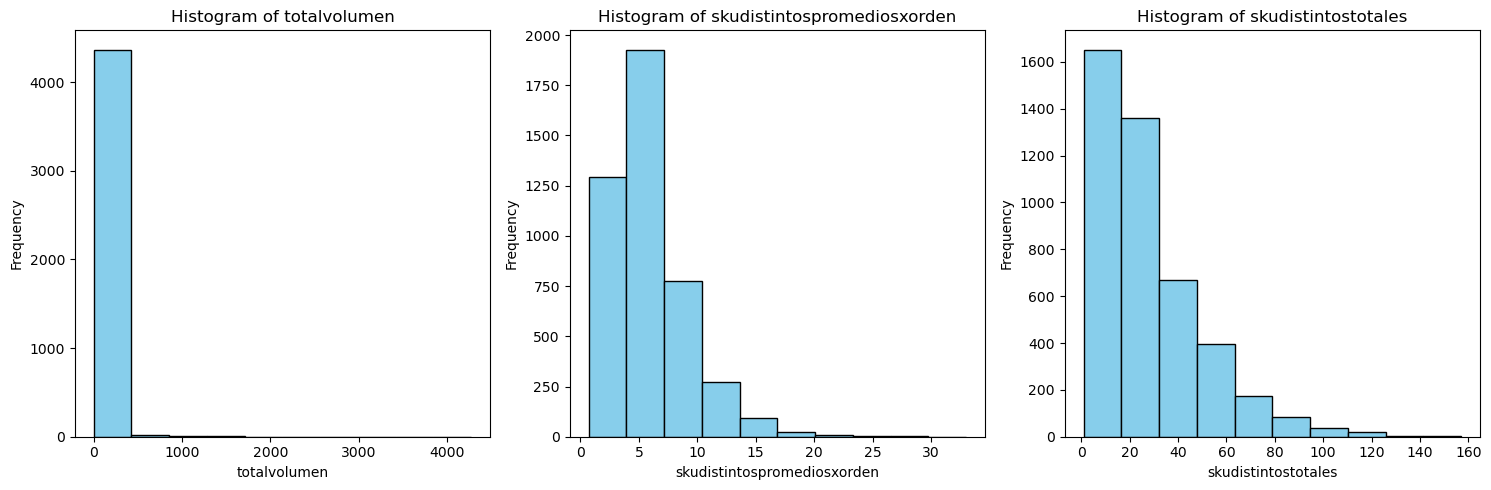

shape: (16, 2)
┌────────────┬────────────────────┐
│ volume_bin ┆ poc_distinct_count │
│ ---        ┆ ---                │
│ f64        ┆ u32                │
╞════════════╪════════════════════╡
│ 0.0        ┆ 4261               │
│ 100.0      ┆ 61                 │
│ 200.0      ┆ 28                 │
│ 300.0      ┆ 15                 │
│ 400.0      ┆ 7                  │
│ 500.0      ┆ 4                  │
│ 600.0      ┆ 5                  │
│ 700.0      ┆ 3                  │
│ 800.0      ┆ 3                  │
│ 900.0      ┆ 2                  │
│ 1000.0     ┆ 3                  │
│ 1100.0     ┆ 2                  │
│ 1200.0     ┆ 1                  │
│ 1300.0     ┆ 1                  │
│ 1600.0     ┆ 3                  │
│ 4200.0     ┆ 1                  │
└────────────┴────────────────────┘


In [26]:
# measures of central tendency for numerical data
print(atributes[numerical].describe())
plot_histograms(atributes, numerical)
# Contar los valores distintos de 'pocr' en bloques de 500 en la columna 'totalvolumen'
result = count_distinct_in_bins(atributes, volume_column="totalvolumen", column="poc", bin_size=100)
# Mostrar el resultado
print(result)

In [27]:
# Filtrar los resultados para mostrar solo aquellos clientes con volumen de compra menores o iguales a 100 (97% de los datos)
outliers = atributes.filter(pl.col("totalvolumen") > 100)
filtered_result = atributes.filter(pl.col("totalvolumen") <= 100)
print(filtered_result[numerical].describe())
outliers[numerical].describe()

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4261.0       ┆ 4261.0                      ┆ 4261.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 10.555502    ┆ 5.949519                    ┆ 27.481342           │
│ std        ┆ 14.581388    ┆ 3.193991                    ┆ 21.533846           │
│ min        ┆ 0.02124      ┆ 0.75                        ┆ 1.0                 │
│ 25%        ┆ 2.03756      ┆ 3.7143                      ┆ 12.0                │
│ 50%        ┆ 5.31534      ┆ 5.2                         ┆ 21.0                │
│ 

statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",139.0,139.0,139.0
"""null_count""",0.0,0.0,0.0
"""mean""",381.454472,4.731182,38.604317
"""std""",470.928405,3.960411,22.200868
"""min""",100.71814,0.7027,3.0
"""25%""",135.84414,2.4831,24.0
"""50%""",231.26044,3.54,32.0
"""75%""",409.65216,5.2222,51.0
"""max""",4274.44416,25.6923,112.0


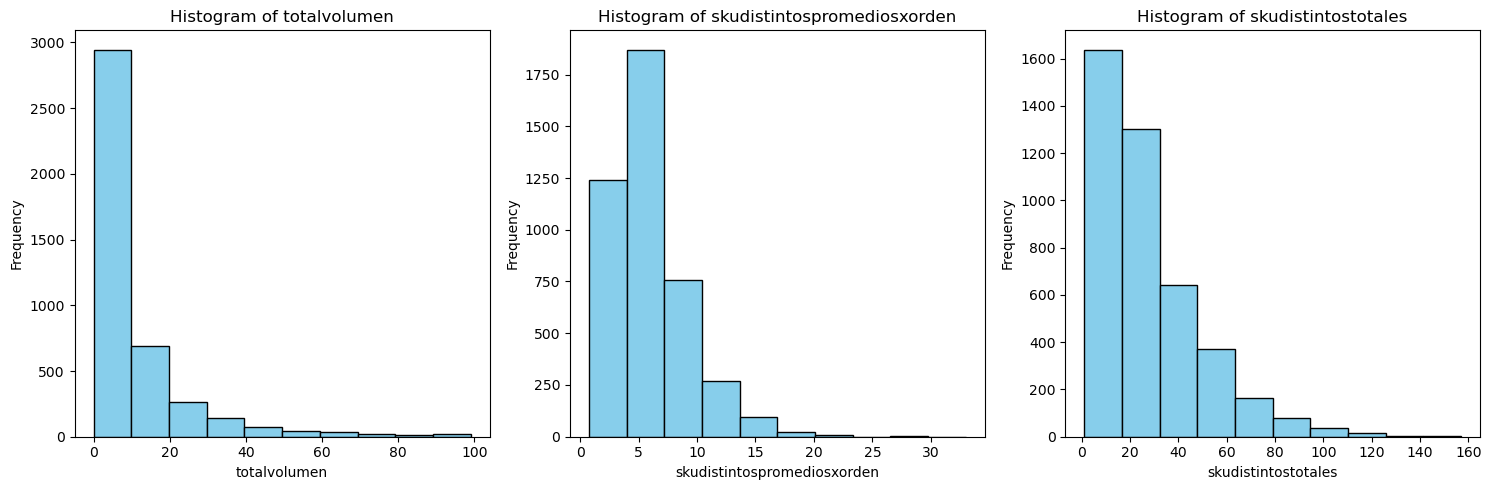

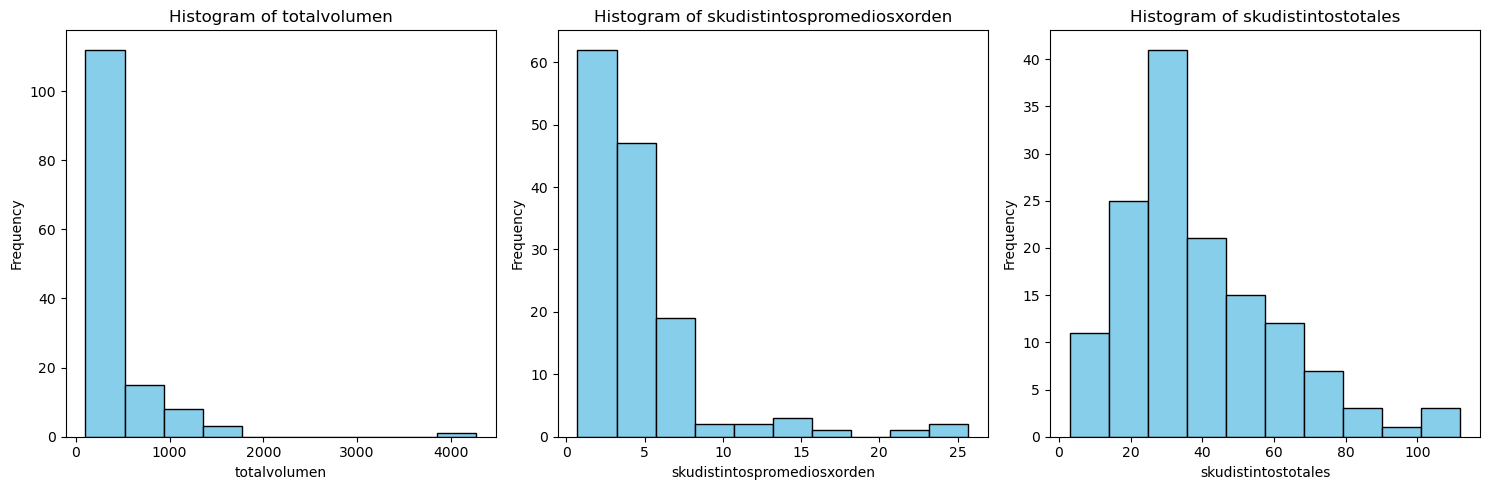

In [28]:

plot_histograms(filtered_result, numerical)
plot_histograms(outliers, numerical)

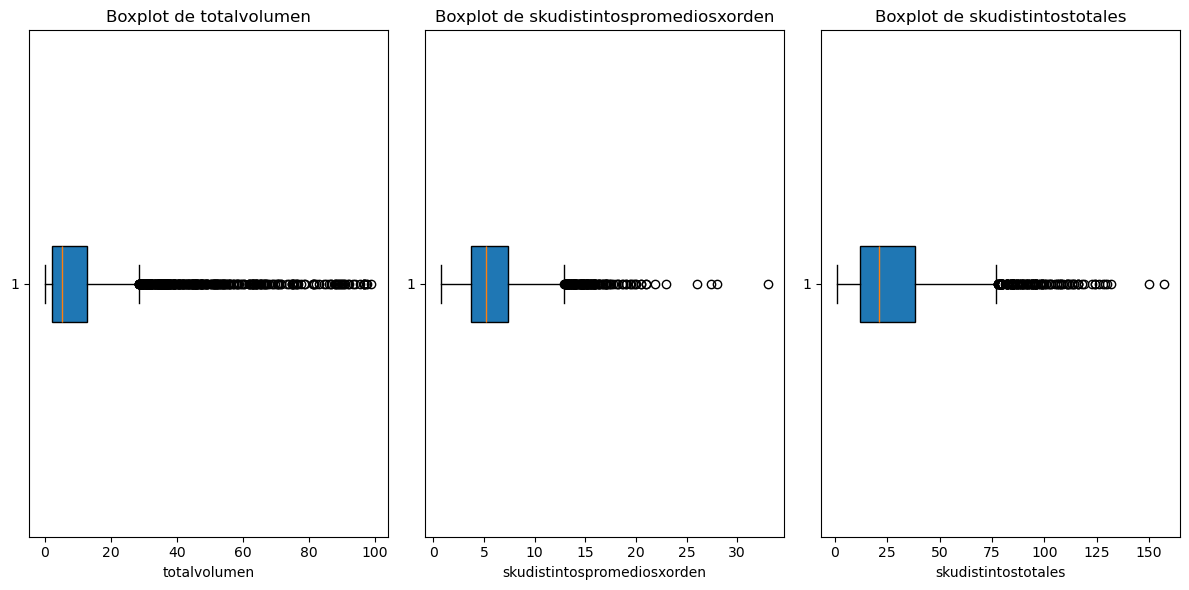

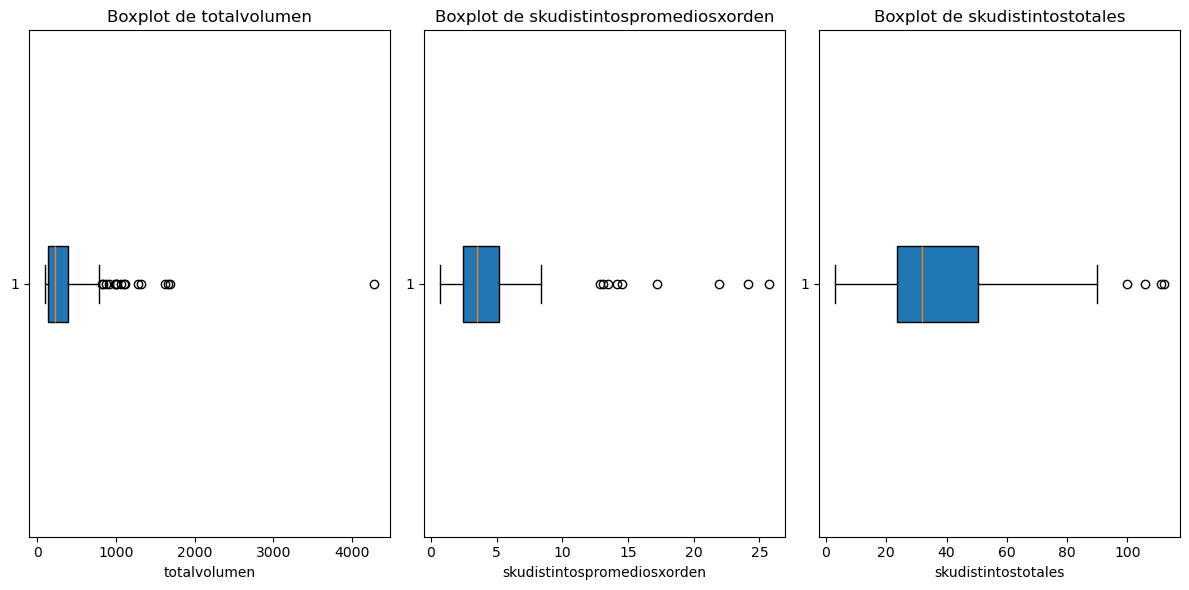

In [29]:
plot_boxplots(filtered_result, numerical)
plot_boxplots(outliers, numerical)

#### Almacenamiento de atributes

In [30]:
atributes.write_parquet("../data/processed/atributes.parquet")
print(atributes.shape)
atributes.head()

(4400, 9)


column_0,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,segmentounico,canal
i64,i64,str,f64,f64,i64,str,str,str
10,175519,"""HighUsage""",5.18752,4.1,16,"""Medio""","""4.Activos""","""Kioscos/Maxikioscos"""
13,28533,"""HighUsage""",4.76866,3.9211,34,"""Alto""","""4.Activos""","""Tradicional"""
19,32182,"""PowerUsage""",5.9793,6.75,34,"""Alto""","""4.Activos""","""Tradicional"""
20,327976,"""MinimalUsage""",6.02852,3.5833,14,"""Alto""","""4.Activos""","""COMIDA"""
24,354640,"""PowerUsage""",7.525,3.2,18,"""Bajo""","""4.Activos""","""Tradicional"""


### Datos de transacciones de los clientes

#### Calidad de los datos:
* Revisar valores nulos
* Revisar valores fuera de rango
* Cuantificar outliers

Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte con agrupación por cliente: Dado que estamos interesados en el comportamiento de compra de los clientes, vamos a agrupar los datos por account_id para analizar patrones de compra individuales.

* Crear dataset aparte con agrupación por item: Dado que también estamos interesados en el comportamiento de compra sobre los items, vamos a agrupar los datos por sku_id para analizar patrones de compra que se dan en general para los items.

##### Calidad de los datos:
* Revisar valores nulos --> No hay valores nulos en este dataset
* Revisar valores fuera de rango --> no se identifican valores fuera de rango (ejemplo: cantidad de bultos comprados del producto negativos )
* Cuantificar outliers --> vemos que hay bastantes outliers en la cantidad de bultos por SKU que se compran, lo cual no ocurre cuando vemos los datos como canastas y calculamos la cantidad de sku por canasta.

In [31]:
check_null_values(transactions)

column,null_count,null_percentage
str,u32,f64
"""""",0,0.0
"""account_id""",0,0.0
"""sku_id""",0,0.0
"""invoice_date""",0,0.0
"""order_id""",0,0.0
"""items_phys_cases""",0,0.0


In [32]:
transactions.head()

,account_id,sku_id,invoice_date,order_id,items_phys_cases
i64,i64,i64,i64,str,f64
0,430606,7038,20220729,"""512-3880249-0""",100.0
1,323267,14933,20220729,"""512-3882307-0""",1.0
2,357825,21971,20220723,"""512-3852880-0""",8.0
3,444926,7038,20220805,"""512-3913163-0""",20.0
4,450771,7030,20220816,"""512-3957000-0""",5.0


shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 280828.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 3.967979  │
│ std        ┆ 18.842399 │
│ min        ┆ 0.083333  │
│ 25%        ┆ 1.0       │
│ 50%        ┆ 1.0       │
│ 75%        ┆ 2.0       │
│ max        ┆ 2000.0    │
└────────────┴───────────┘


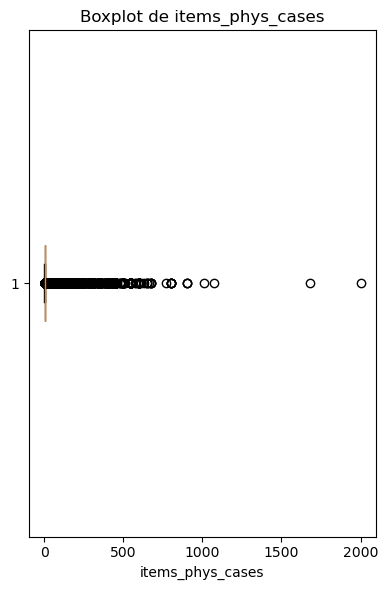

In [33]:
print(transactions['items_phys_cases'].describe())
plot_boxplots(transactions, ["items_phys_cases"])

shape: (9, 2)
┌────────────┬─────────┐
│ statistic  ┆ value   │
│ ---        ┆ ---     │
│ str        ┆ f64     │
╞════════════╪═════════╡
│ count      ┆ 45552.0 │
│ null_count ┆ 0.0     │
│ mean       ┆ 1.0     │
│ std        ┆ 0.0     │
│ min        ┆ 1.0     │
│ 25%        ┆ 1.0     │
│ 50%        ┆ 1.0     │
│ 75%        ┆ 1.0     │
│ max        ┆ 1.0     │
└────────────┴─────────┘


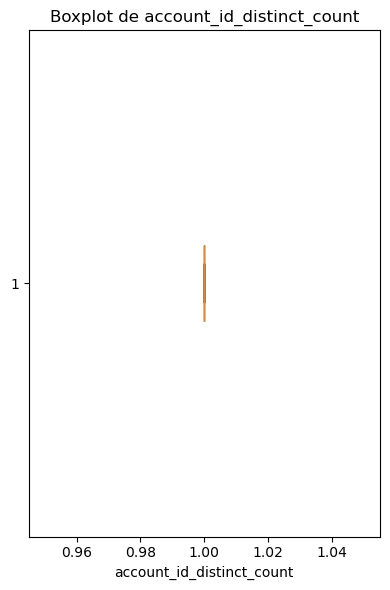

In [34]:
result = count_distinct_grouped_by(transactions, y_column="account_id", x_columns=['invoice_date','account_id',"order_id"],z_columns=['invoice_date','account_id',"order_id"])
print(result['account_id_distinct_count'].describe())
plot_boxplots(result, ["account_id_distinct_count"])

##### Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte de las canastas que es una agrupación por fecha-usuario-orden que contiene 1 o mas sku y que contiene 1 o más cantidades pedidas de cada sku

In [35]:
# Transform the f64 column to i64 (integer)
transactions = transactions.with_columns(
    pl.col("items_phys_cases").cast(pl.Int64).alias("items_phys_cases")
)
# Transform the f64 column to utf8 (string)
transactions = transactions.with_columns(pl.col("sku_id").cast(pl.Utf8))
transactions = transactions.with_columns(pl.col("order_id").cast(pl.Utf8))
transactions = transactions.with_columns(pl.col("account_id").cast(pl.Utf8))
transactions = transform_to_date(transactions, ['invoice_date'])
transactions.head()

,account_id,sku_id,invoice_date,order_id,items_phys_cases
i64,str,str,date,str,i64
0,"""430606""","""7038""",2022-07-29,"""512-3880249-0""",100
1,"""323267""","""14933""",2022-07-29,"""512-3882307-0""",1
2,"""357825""","""21971""",2022-07-23,"""512-3852880-0""",8
3,"""444926""","""7038""",2022-08-05,"""512-3913163-0""",20
4,"""450771""","""7030""",2022-08-16,"""512-3957000-0""",5


In [36]:
# Now let's try to use the function
baskets = create_baskets(
    df=transactions,
    group_cols=['invoice_date','account_id','order_id'],
    list_col='sku_id',
    sum_cols=['items_phys_cases'],
    sort_cols=['invoice_date']
)
print(baskets .head())

shape: (5, 6)
┌──────────────┬────────────┬────────────────┬───────────────────┬──────────────┬──────────────────┐
│ invoice_date ┆ account_id ┆ order_id       ┆ sku_id            ┆ sku_id_count ┆ items_phys_cases │
│ ---          ┆ ---        ┆ ---            ┆ ---               ┆ ---          ┆ ---              │
│ date         ┆ str        ┆ str            ┆ list[str]         ┆ u32          ┆ i64              │
╞══════════════╪════════════╪════════════════╪═══════════════════╪══════════════╪══════════════════╡
│ 2022-05-24   ┆ 75296      ┆ 512-3601848-0  ┆ ["19088",         ┆ 3            ┆ 5                │
│              ┆            ┆                ┆ "77676", "7038"]  ┆              ┆                  │
│ 2022-05-24   ┆ 417417     ┆ 102-38960009-0 ┆ ["7651"]          ┆ 1            ┆ 3                │
│ 2022-05-24   ┆ 419425     ┆ 512-3602490-0  ┆ ["24118", "7651", ┆ 11           ┆ 20               │
│              ┆            ┆                ┆ … "7038"]         ┆           

#### Almacenamiento de transactions y baskets

In [37]:

# Save the DataFrame to a Parquet file
baskets.write_parquet("../data/processed/baskets.parquet")
print(baskets.shape)
transactions.write_parquet("../data/processed/transactions.parquet")
print(transactions.shape)
transactions.head()

(45552, 6)
(280828, 6)


,account_id,sku_id,invoice_date,order_id,items_phys_cases
i64,str,str,date,str,i64
0,"""430606""","""7038""",2022-07-29,"""512-3880249-0""",100
1,"""323267""","""14933""",2022-07-29,"""512-3882307-0""",1
2,"""357825""","""21971""",2022-07-23,"""512-3852880-0""",8
3,"""444926""","""7038""",2022-08-05,"""512-3913163-0""",20
4,"""450771""","""7030""",2022-08-16,"""512-3957000-0""",5


## EDA -- Preguntas a contestar para tener una radiografía clara de mis clientes en base a su comportamiento de consumo

**Sobre las clientes**

* **Análisis a la caracterización de los clientes**
    * ¿A cúantos clientes se les debe hacer recomendación? ¿Cuánto compran los clientes en cada compra? ¿Con qué frecuencia los clientes realizan compras?
    * Si los categorizo ¿Hay diferencias significativas en la distribución de clientes por categoría? ¿Las variables de consumo son distintas entre las categorías?  ¿Estas categorías son independientes entre si? 
  
* **Análisis transaccional general**
    * Con qué frecuencia
    * Cuántos productos se llevan en cada compra
    * Cuántos items de esos productos se llevan en cada compra
    * ¿Cómo varía la frecuencia de compra a lo largo del tiempo?

* **Análisis transaccional temporal**

    * ¿Existen clientes con comportamiento de compra repetitivo? ¿Quienes?
    * ¿Cuántas compras hicieorn en el periodo analizado? ¿En qué rango se mueve?
    * ¿cuál es la frecuencia de compra en el periodo analizado?
    * Cuál es el tiempo desde la última compra
    * Qué antiguedad tienen y cómo se distribuye

* **Sobre los items**
    * ¿Cuál es la cantidad total de items disponibles para recomendación?
    * ¿Cuál es el ratio de items por cliente?
    * ¿Cuál es la cantidad de items promedio que cada cliente compra?

* **Análisis de cohorte sobre las transacciones**
    * ¿Cómo se comportan las diferentes cohortes de clientes a lo largo del tiempo?
    * ¿Cómo evolucionan las ventas en diferentes cohortes?

### Análisis sobre los clientes 

##### 3 preguntas a contestar: ¿A cúantos clientes se les debe hacer recomendación? ¿Cuánto compran los clientes en cada compra? ¿Con qué frecuencia los clientes realizan compras?
 
* R: hay 4400 clientes en la base de datos de atributos y 4535 en la de transacciones.  

* R: De las transacciones registradas, podemos notar que se compran, en promedio, 5.7 productos distintos y 17 unidades por compra. También sabemos, por el dataset de atributos , que el 75% de los clientes compró 14 helectrolitros o menos pero que hubo algunos pocos que pasaron los 100 y llegaron hasta 4274. 

In [38]:
group_and_describe_with_percentiles(baskets, "account_id", ['sku_id_count','items_phys_cases']).select(pl.all().mean())

account_id,count,sku_id_count_mean,items_phys_cases_mean,sku_id_count_median,items_phys_cases_median,sku_id_count_std_dev,items_phys_cases_std_dev,sku_id_count_p25,sku_id_count_p50,sku_id_count_p75,items_phys_cases_p25,items_phys_cases_p50,items_phys_cases_p75
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
null,10.044542,5.722985,16.955941,5.499669,15.488864,2.354361,9.086522,4.427122,5.705182,7.014333,11.71731,16.16097,21.396251


In [39]:
print(transactions.select('account_id').unique().height)
print(transactions.select('sku_id').unique().height)
# measures of central tendency for numerical data
print(atributes.select('poc').unique().height)
atributes[numerical].describe()

4535
530
4400


statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",4400.0,4400.0,4400.0
"""null_count""",0.0,0.0,0.0
"""mean""",22.272537,5.911031,27.832727
"""std""",106.642437,3.227491,21.640289
"""min""",0.02124,0.7027,1.0
"""25%""",2.12124,3.6667,12.0
"""50%""",5.6011,5.1429,22.0
"""75%""",13.95536,7.3542,38.0
"""max""",4274.44416,33.0,157.0


#### Si los categorizo ¿Hay diferencias significativas en la distribución de clientes por categoría? ¿Las variables de consumo son distintas entre las categorías?  ¿Estas categorías son independientes entre si? 

El objetivo de estas preguntas es entender qué variables debo usar para generar una segmentación única en los clientes que me permita diferenciarlos entre si con una única métrica / segmentación

A continuación se presentan los resultados por categoría

* Segmento de negocio : aunque es homogenea, es importante notar que solo un 21% de los clientes tiene un nivel de uso bajo o nulo de la aplicación (potencialmente descartable para el MVP)
* Concentración : No es homogenea y vemos que el 90% se concentra en niveles alto y medio 
* Segmento único: No es homogenea y los clientes con capacidad media de compra son el 61%, mientras que el 20% es de baja y el 17% es de alta, el resto no tiene datos
* Canal : el 88% de los clientes pertenece a 3 canales: tradidicional, Kioscos o Maxikioscos  o Comida

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

* Para contestar a la pregunta sobre las variables de consumo, recurrimos al  test de Kruskal-Wallis para evaluar la independencia entre cada una de las categorías y variables de consumo. Los resultados, usando un 99% de confianza, nos muestran que efectivamente en ninguna se cumple la independencia, lo que implica que estas categorías logran identificar patrones de consumo distintos entre los clientes, y por lo tanto deben ser usadas para generar una segmentación única.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

* Las categorías no son independientes entre si, esto ya lo demostramos previamente en la sección de imputación de datos.

In [40]:
print(count_distinct_grouped_by(atributes, y_column="poc", x_columns=["bussinesssegment"],z_columns=["poc_percentage"]))
kruskal_wallis_test_multiple(atributes, numerical, 'bussinesssegment')

shape: (4, 4)
┌──────────────────┬────────────────────┬────────────────────┬────────────────┐
│ bussinesssegment ┆ poc_distinct_count ┆ total_first_column ┆ poc_percentage │
│ ---              ┆ ---                ┆ ---                ┆ ---            │
│ str              ┆ u32                ┆ i32                ┆ f64            │
╞══════════════════╪════════════════════╪════════════════════╪════════════════╡
│ HighUsage        ┆ 1213               ┆ 4400               ┆ 27.568182      │
│ PowerUsage       ┆ 1213               ┆ 4400               ┆ 27.568182      │
│ MediumUsage      ┆ 1050               ┆ 4400               ┆ 23.863636      │
│ MinimalUsage     ┆ 924                ┆ 4400               ┆ 21.0           │
└──────────────────┴────────────────────┴────────────────────┴────────────────┘


{'totalvolumen': {'estadistico': 519.1444207816274,
  'p_valor': 3.3856314723110925e-112,
  'rechaza_hipotesis_nula de independencia': True},
 'skudistintospromediosxorden': {'estadistico': 5.377362621836753,
  'p_valor': 0.1461604870505244,
  'rechaza_hipotesis_nula de independencia': False},
 'skudistintostotales': {'estadistico': 819.065284985969,
  'p_valor': 3.1722089885162538e-177,
  'rechaza_hipotesis_nula de independencia': True}}

In [41]:
print(count_distinct_grouped_by(atributes, y_column="poc", x_columns=["concentracion"],z_columns=["poc_percentage"]))
kruskal_wallis_test_multiple(atributes, numerical, 'concentracion')

shape: (3, 4)
┌───────────────┬────────────────────┬────────────────────┬────────────────┐
│ concentracion ┆ poc_distinct_count ┆ total_first_column ┆ poc_percentage │
│ ---           ┆ ---                ┆ ---                ┆ ---            │
│ str           ┆ u32                ┆ i32                ┆ f64            │
╞═══════════════╪════════════════════╪════════════════════╪════════════════╡
│ Alto          ┆ 2319               ┆ 4400               ┆ 52.704545      │
│ Medio         ┆ 1954               ┆ 4400               ┆ 44.409091      │
│ Bajo          ┆ 127                ┆ 4400               ┆ 2.886364       │
└───────────────┴────────────────────┴────────────────────┴────────────────┘


{'totalvolumen': {'estadistico': 0.0014147639136451386,
  'p_valor': 0.9992928681788099,
  'rechaza_hipotesis_nula de independencia': False},
 'skudistintospromediosxorden': {'estadistico': 173.1552414485415,
  'p_valor': 2.510828578193066e-38,
  'rechaza_hipotesis_nula de independencia': True},
 'skudistintostotales': {'estadistico': 63.96406766509979,
  'p_valor': 1.2893748253198242e-14,
  'rechaza_hipotesis_nula de independencia': True}}

In [42]:
print(count_distinct_grouped_by(atributes, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"]))
kruskal_wallis_test_multiple(atributes, numerical, 'segmentounico')

shape: (5, 4)
┌───────────────┬────────────────────┬────────────────────┬────────────────┐
│ segmentounico ┆ poc_distinct_count ┆ total_first_column ┆ poc_percentage │
│ ---           ┆ ---                ┆ ---                ┆ ---            │
│ str           ┆ u32                ┆ i32                ┆ f64            │
╞═══════════════╪════════════════════╪════════════════════╪════════════════╡
│ 4.Activos     ┆ 1934               ┆ 4400               ┆ 43.954545      │
│ 1.Inactivos   ┆ 888                ┆ 4400               ┆ 20.181818      │
│ 2.Masivos     ┆ 820                ┆ 4400               ┆ 18.636364      │
│ 5.Select      ┆ 631                ┆ 4400               ┆ 14.340909      │
│ 3.Potenciales ┆ 127                ┆ 4400               ┆ 2.886364       │
└───────────────┴────────────────────┴────────────────────┴────────────────┘


{'totalvolumen': {'estadistico': 1430.6524512984681,
  'p_valor': 1.559115508200122e-308,
  'rechaza_hipotesis_nula de independencia': True},
 'skudistintospromediosxorden': {'estadistico': 327.37901311534944,
  'p_valor': 1.3403446489580167e-69,
  'rechaza_hipotesis_nula de independencia': True},
 'skudistintostotales': {'estadistico': 1500.5826861555747,
  'p_valor': 0.0,
  'rechaza_hipotesis_nula de independencia': True}}

In [43]:
print(count_distinct_grouped_by(atributes, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"]))
kruskal_wallis_test_multiple(atributes, numerical, 'canal')

shape: (11, 4)
┌─────────────────────┬────────────────────┬────────────────────┬────────────────┐
│ canal               ┆ poc_distinct_count ┆ total_first_column ┆ poc_percentage │
│ ---                 ┆ ---                ┆ ---                ┆ ---            │
│ str                 ┆ u32                ┆ i32                ┆ f64            │
╞═════════════════════╪════════════════════╪════════════════════╪════════════════╡
│ Tradicional         ┆ 2665               ┆ 4400               ┆ 60.568182      │
│ Kioscos/Maxikioscos ┆ 821                ┆ 4400               ┆ 18.659091      │
│ COMIDA              ┆ 415                ┆ 4400               ┆ 9.431818       │
│ Autoservicio        ┆ 186                ┆ 4400               ┆ 4.227273       │
│ BEBIDA              ┆ 101                ┆ 4400               ┆ 2.295455       │
│ ENTRETENIMIENTO     ┆ 79                 ┆ 4400               ┆ 1.795455       │
│ Mayorista           ┆ 53                 ┆ 4400               ┆ 1.2045

{'totalvolumen': {'estadistico': 379.13231327592615,
  'p_valor': 2.585284414806595e-75,
  'rechaza_hipotesis_nula de independencia': True},
 'skudistintospromediosxorden': {'estadistico': 112.60145540518336,
  'p_valor': 1.5927427428372311e-19,
  'rechaza_hipotesis_nula de independencia': True},
 'skudistintostotales': {'estadistico': 227.7865238306771,
  'p_valor': 2.5000660806140025e-43,
  'rechaza_hipotesis_nula de independencia': True}}

#### Analisis transaccional general

* Hay al menos un 25% que no lleva nada semanal o bimensual e incluso cuando miramos de forma mensual

* Con qué frecuencia -- En promedio, se hacen 2.5 compras mensuales y la mediana es de 2. Es importante notar la disperción en la frecuencia, pues el 75% que menos compra hace 1 o ninguna compra semanal y solo cuando lo llevamos a bisemanal vemos que la frecuencia sube a 2 para el percentil 75. 

* Cuántos productos se llevan en cada compra -- El promedio es de 4 sku mensuales pero solo el 50% superior se lleva, en promedio, de 3 a 50. 

* Cuántos items de esos productos se llevan en cada compra --  4 en promedio mensual o bisemanal, pero el 50% de los clientes que más compra se lleva entre 3 y 50 productos cada dos semanas. 

* ¿Cómo varía la frecuencia de compra y la cantidad de sku por compra a lo largo del tiempo? -- La frecuencia semanal de compra se mantiene constante y la cantidad de sku por compra va en aumento. Es importante notar que las semanas 21 y 35 no tendrán datos representativos 

In [44]:
weekly_result = process_baskets_weekly(
    baskets, 
    count_column="order_id", 
    unique_column="order_id", 
    mean_columns=["sku_id_count", "items_phys_cases"]
)

biweekly_result = process_baskets_biweekly(
    baskets, 
    count_column="order_id", 
    unique_column="order_id", 
    mean_columns=["sku_id_count", "items_phys_cases"]
)
monthly_result = process_baskets_monthly(
    baskets, 
    count_column="order_id", 
    unique_column="order_id", 
    mean_columns=["sku_id_count", "items_phys_cases"]
)

In [45]:
# Comparamos los resultados para mensual, bisemanal y semanal
numerical = ["frec_order_id","total_order_id","avg_sku_id_count","avg_items_phys_cases"]
stats_monthly = calculate_statistics(monthly_result, numerical)
stats_biweekly = calculate_statistics(biweekly_result, numerical)
stats_weekly = calculate_statistics(weekly_result, numerical)
print(stats_monthly)
stats_biweekly

shape: (4, 8)
┌──────────────────────┬───────────┬───────────┬─────┬─────┬──────────┬──────┬────────┐
│ variable             ┆ mean      ┆ std_dev   ┆ p0  ┆ p25 ┆ p50      ┆ p75  ┆ p100   │
│ ---                  ┆ ---       ┆ ---       ┆ --- ┆ --- ┆ ---      ┆ ---  ┆ ---    │
│ str                  ┆ f64       ┆ f64       ┆ f64 ┆ f64 ┆ f64      ┆ f64  ┆ f64    │
╞══════════════════════╪═══════════╪═══════════╪═════╪═════╪══════════╪══════╪════════╡
│ frec_order_id        ┆ 2.511136  ┆ 2.9286    ┆ 0.0 ┆ 0.0 ┆ 2.0      ┆ 4.0  ┆ 41.0   │
│ total_order_id       ┆ 2.51086   ┆ 2.928488  ┆ 0.0 ┆ 0.0 ┆ 2.0      ┆ 4.0  ┆ 41.0   │
│ avg_sku_id_count     ┆ 4.028173  ┆ 4.206093  ┆ 0.0 ┆ 0.0 ┆ 3.285714 ┆ 6.0  ┆ 50.0   │
│ avg_items_phys_cases ┆ 11.397877 ┆ 30.774286 ┆ 0.0 ┆ 0.0 ┆ 5.928571 ┆ 12.0 ┆ 1330.0 │
└──────────────────────┴───────────┴───────────┴─────┴─────┴──────────┴──────┴────────┘


variable,mean,std_dev,p0,p25,p50,p75,p100
str,f64,f64,f64,f64,f64,f64,f64
"""frec_order_id""",1.255568,1.381643,0.0,0.0,1.0,2.0,19.0
"""total_order_id""",1.25543,1.381579,0.0,0.0,1.0,2.0,19.0
"""avg_sku_id_count""",4.092384,4.53742,0.0,0.0,3.0,6.0,50.0
"""avg_items_phys_cases""",11.984287,32.53081,0.0,0.0,6.0,12.5,1420.0


In [46]:
stats_weekly

variable,mean,std_dev,p0,p25,p50,p75,p100
str,f64,f64,f64,f64,f64,f64,f64
"""frec_order_id""",0.669636,0.8182,0.0,0.0,1.0,1.0,13.0
"""total_order_id""",0.669621,0.818167,0.0,0.0,1.0,1.0,13.0
"""avg_sku_id_count""",3.212972,4.52285,0.0,0.0,1.0,5.0,55.0
"""avg_items_phys_cases""",9.537729,28.509767,0.0,0.0,2.0,10.0,1420.0


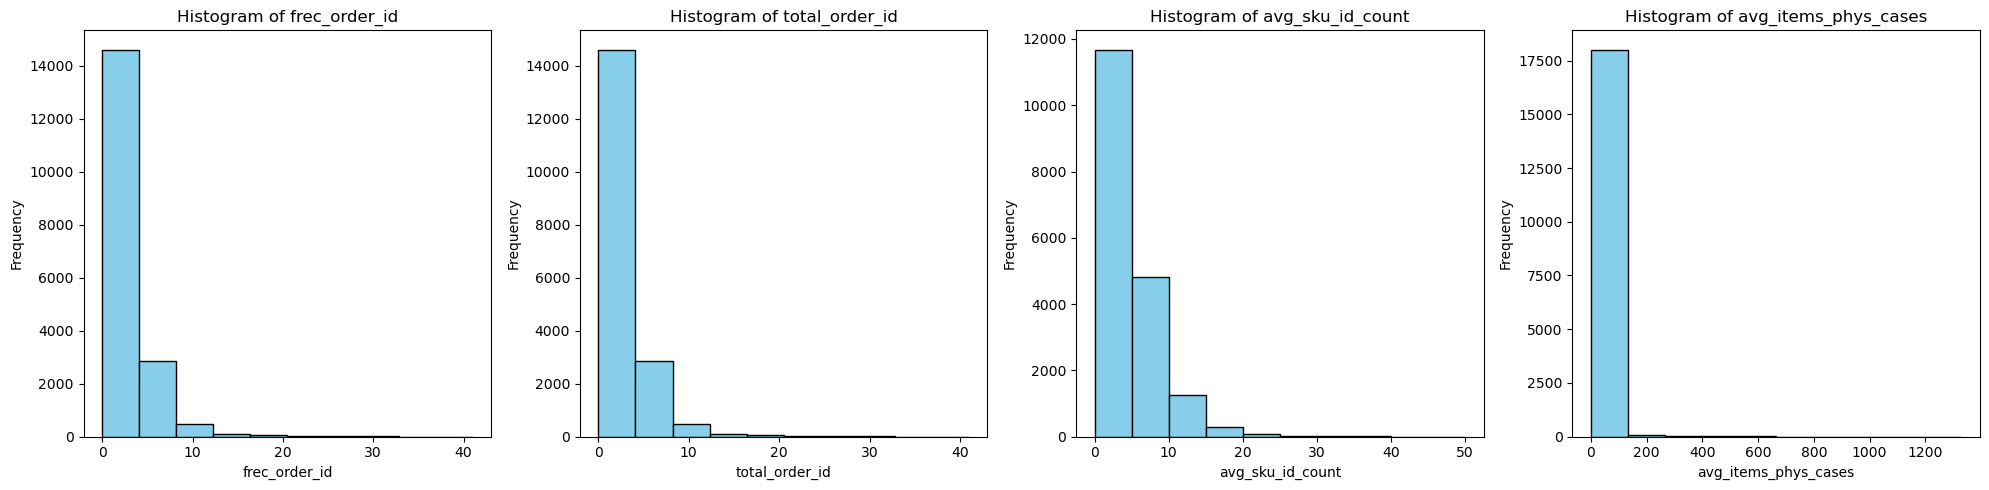

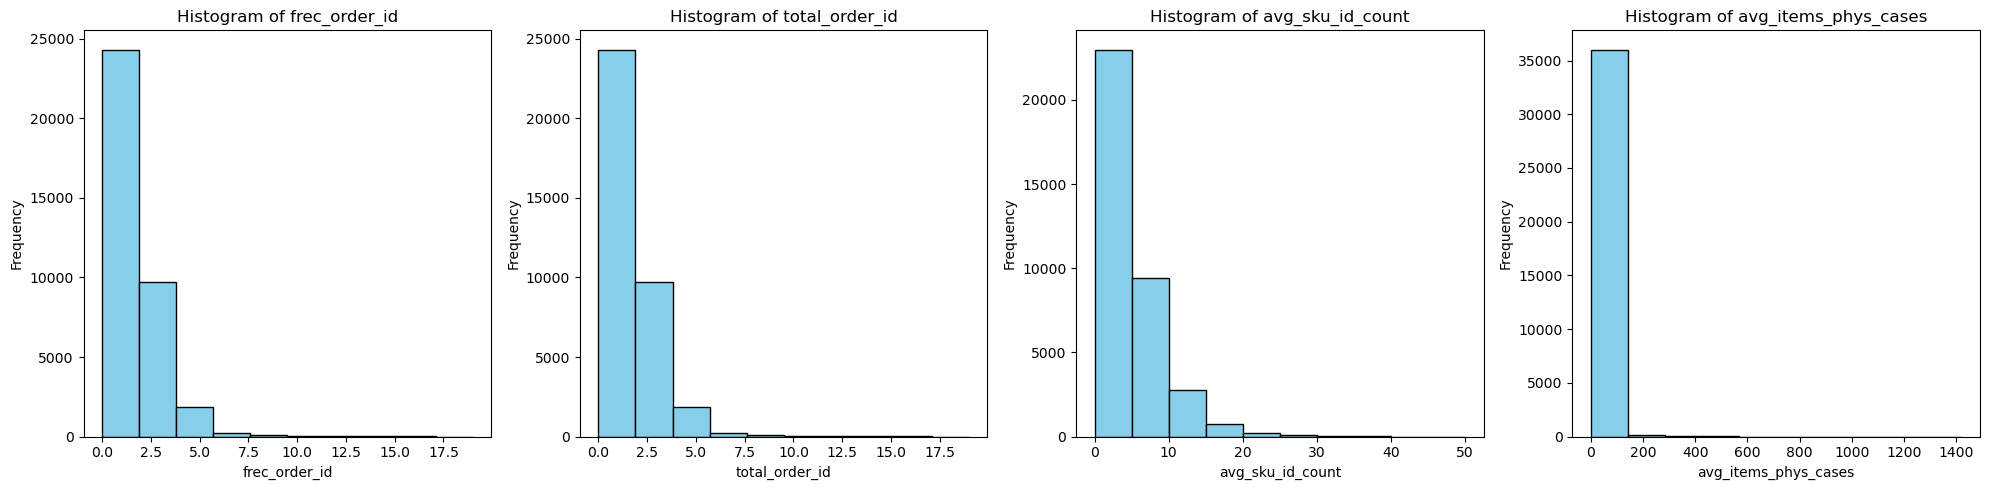

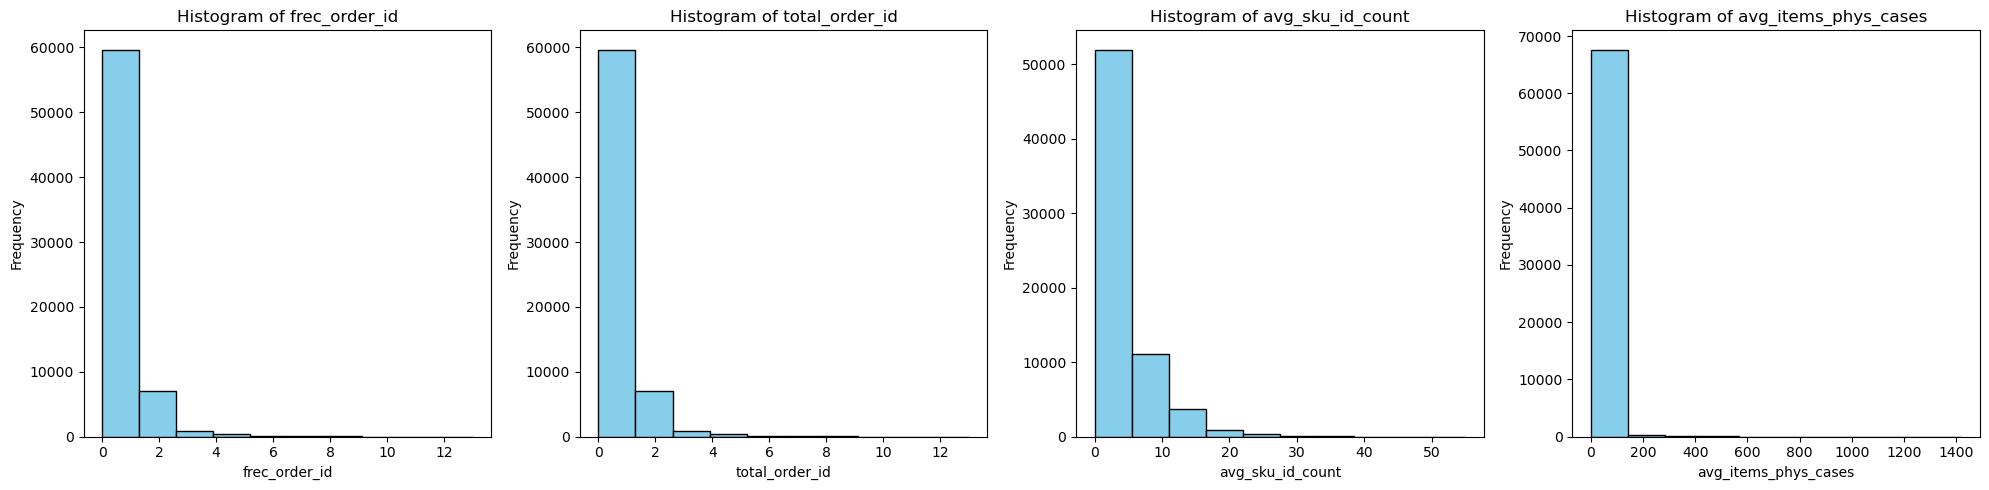

In [47]:
plot_histograms(monthly_result, numerical)
plot_histograms(biweekly_result, numerical)
plot_histograms(weekly_result, numerical)

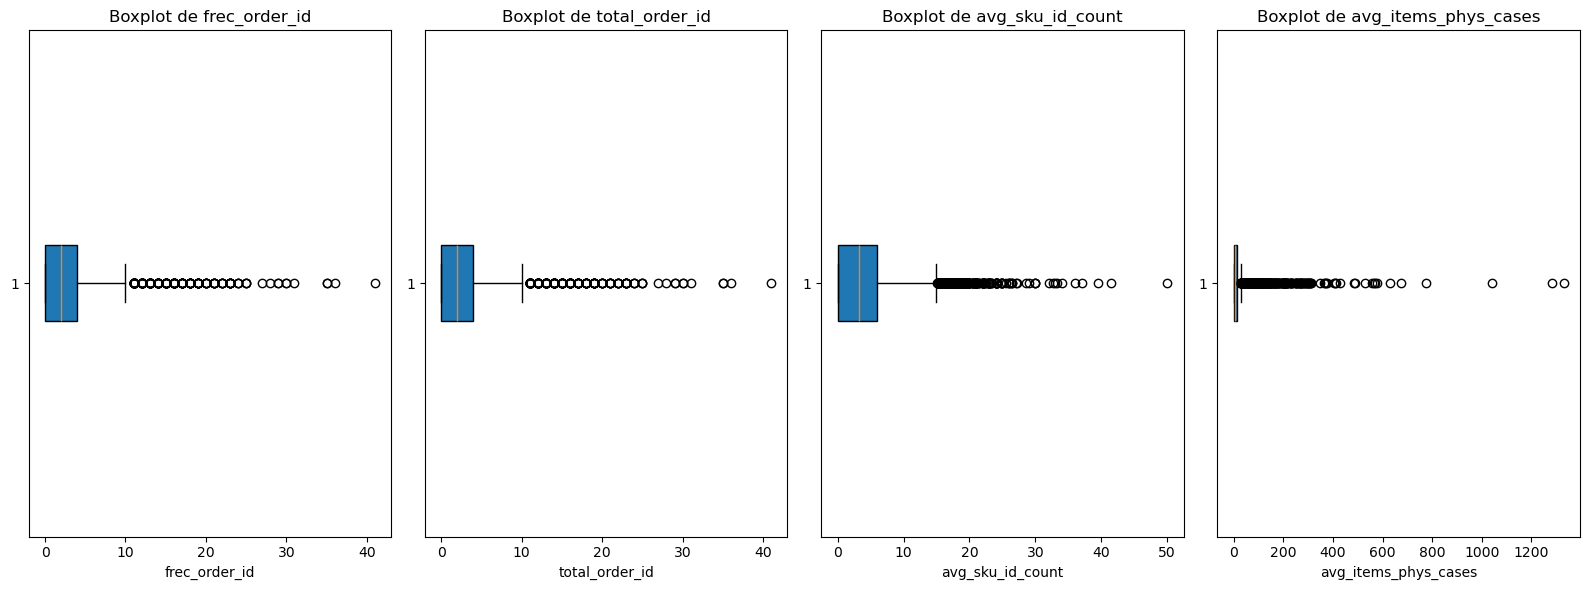

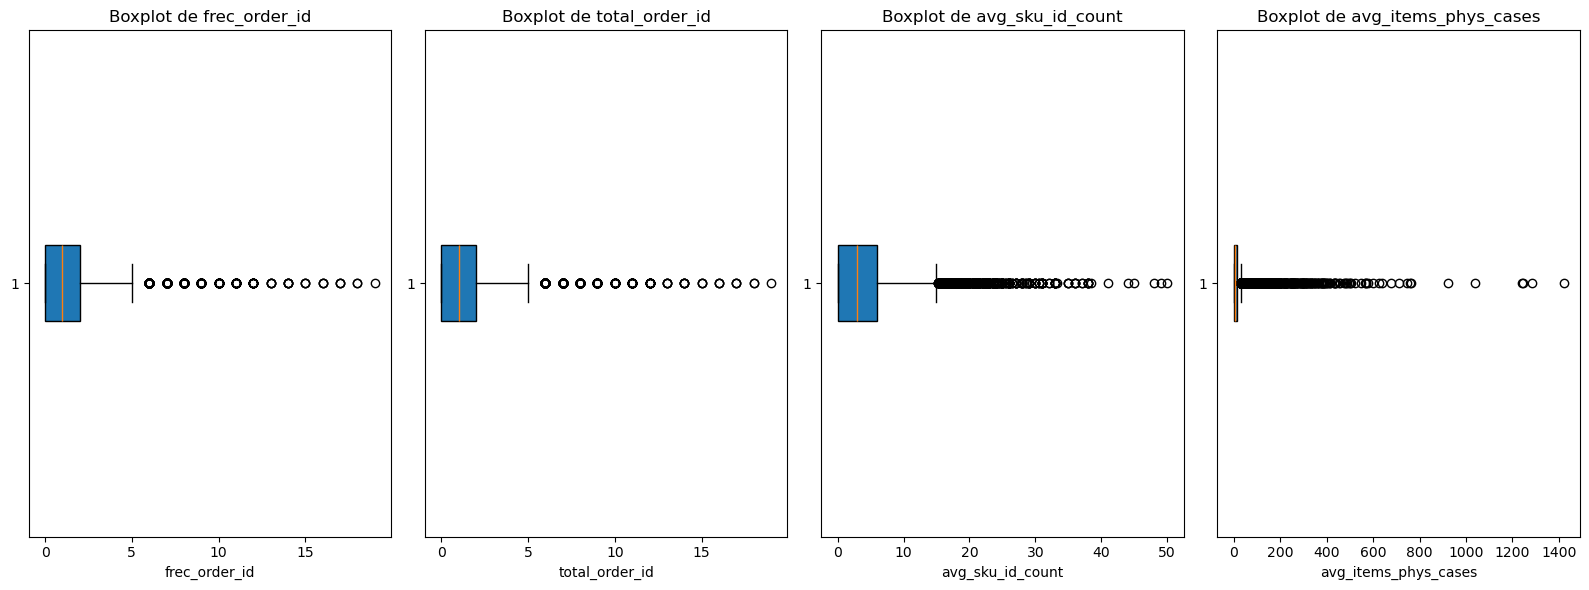

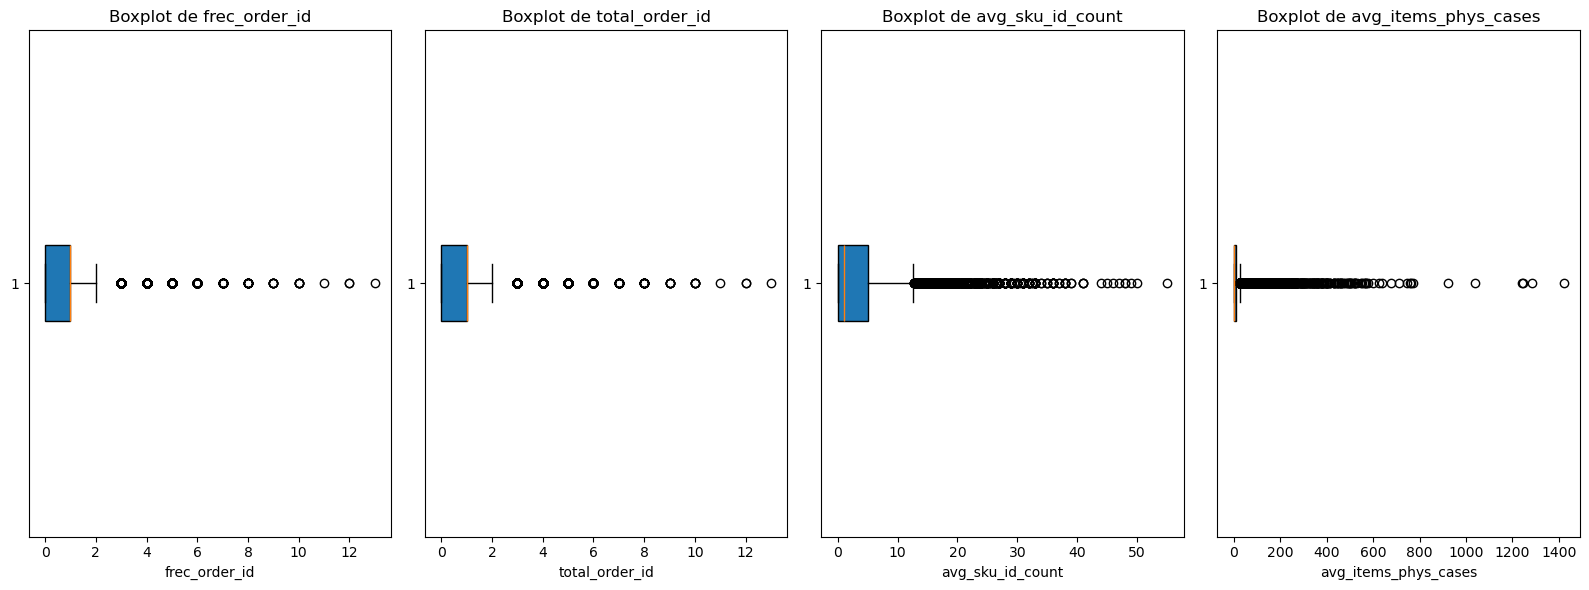

In [48]:
plot_boxplots(monthly_result, numerical)
plot_boxplots(biweekly_result, numerical)
plot_boxplots(weekly_result, numerical)

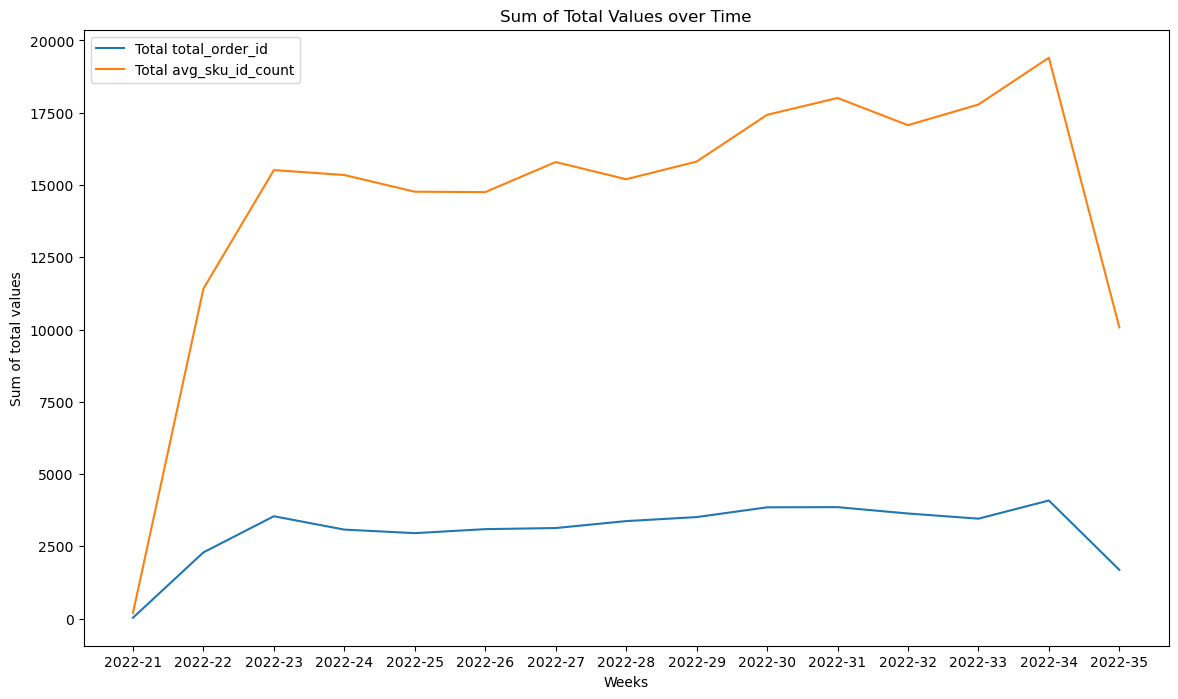

In [49]:
plot_weekly_sum(weekly_result, ["total_order_id", "avg_sku_id_count"],group_by_period='weeks')

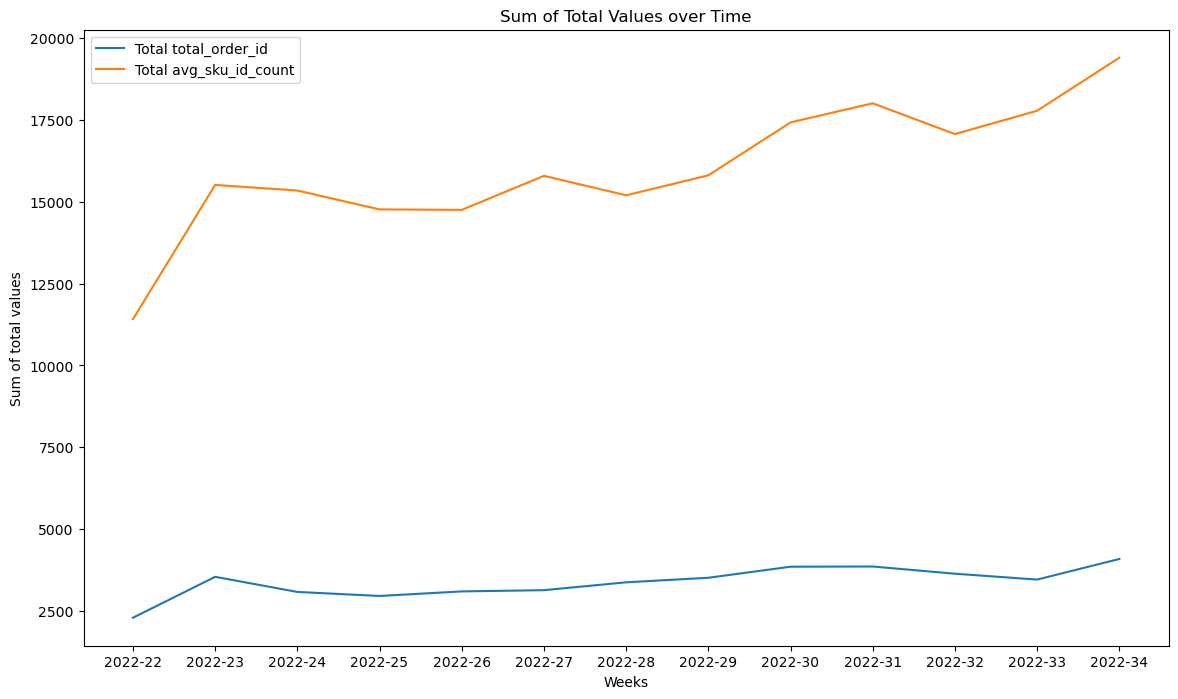

In [50]:
weekly_result_filtered = weekly_result.filter(
    ~pl.col("weeks").is_in(["2022-21", "2022-35"])
)
plot_weekly_sum(weekly_result_filtered, ["total_order_id", "avg_sku_id_count"],group_by_period='weeks')

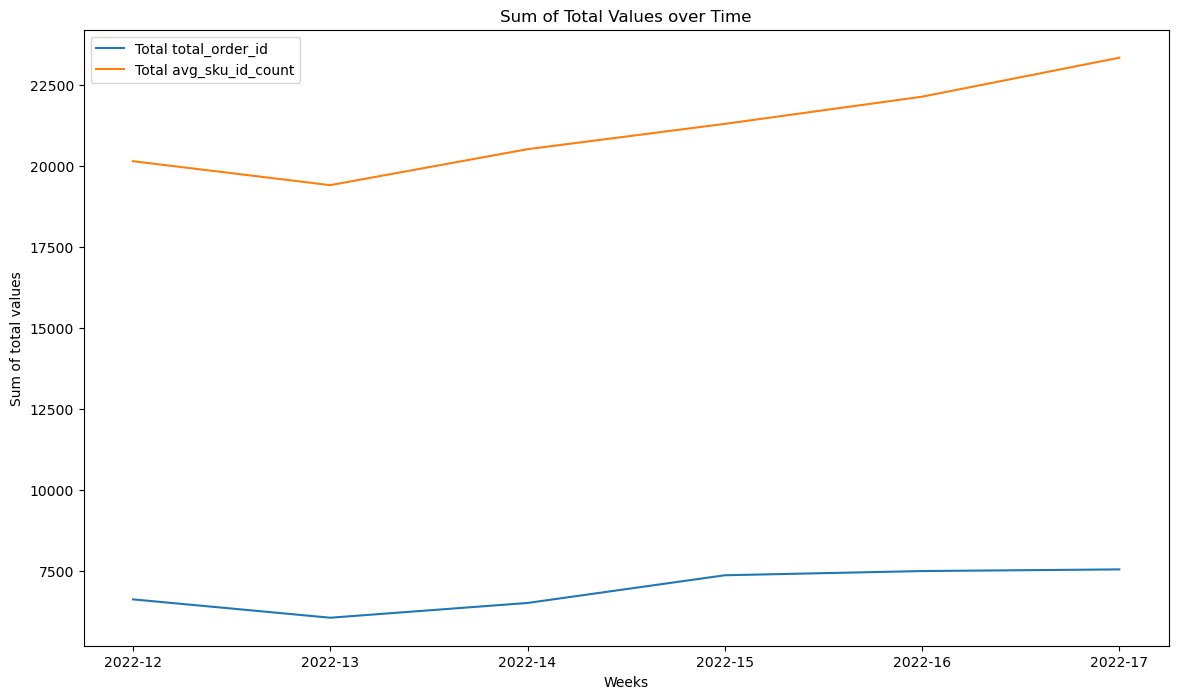

In [51]:

biweekly_result_filtered = biweekly_result.filter(
    ~pl.col("biweekly").is_in(["2022-11", "2022-18"])
)
plot_weekly_sum(biweekly_result_filtered, ["total_order_id", "avg_sku_id_count"],group_by_period='biweekly')

#### Análisis transaccional temporal

* ¿Existen clientes con comportamiento de compra repetitivo? ¿Cuántos son? --> Hay 632 clientes que repitieron la misma compra 12 o mas veces en el periodo y hay 1638 pares de cliente-sku únicos que cumplen este criterio. Usamos 12 porque solo el 25% de los clientes que más compra hace 4 o más compras mensuales. Lo que implicaría que los pares cliente-sku seleccionados están en ese 25% superior y además escogieron en cada compra ese SKU

* ¿cuál es la frecuencia de compra en el periodo analizado? : La frecuencia de compra es de al menos de al menos una compra cada 7 días para el 75% y de al menos una cada 12 días para el 50% de los clientes

* ¿Cuántas compras hicieorn en el periodo analizado? ¿En qué rango se mueve?: 10 compras promedio, y el rango es entre 1 y 67

* Cuál es el tiempo desde la última compra: el 75% de los clientes hizo su última compra hace 11 días o menos

* Qué antiguedad tienen y cómo se distribuye: El 75% de los clientes tiene una antiguedad de 78 días o más

In [52]:
repetitive_purchasers = find_repetitive_purchasers(
    transactions, 
    "account_id", 
    "sku_id", 
    "invoice_date"
)
print(repetitive_purchasers.shape)
repetitive_purchasers.select("account_id").unique().shape

(1638, 3)


(632, 1)

In [53]:
# Group by account_id and calculate desired metrics
client_metrics = baskets.group_by("account_id").agg(
    [
        pl.col("invoice_date").unique().count().alias("total_purchase"),
        pl.col("invoice_date").max().alias("last_purchase_date"),
        pl.col("invoice_date").min().alias("first_purchase_date"),
        baskets["invoice_date"].max()
    ]
)
client_metrics = client_metrics.rename({"literal": "last_purchase_date_basket"})
client_metrics = client_metrics.with_columns([
    baskets["invoice_date"].min(),
])

client_metrics = client_metrics.rename({"literal": "first_purchase_date_basket"})
client_metrics = client_metrics.with_columns([
    (pl.col("last_purchase_date_basket") - pl.col("last_purchase_date")).dt.total_days().alias("days_since_last_purchase"),
    (pl.col("last_purchase_date_basket") - pl.col("first_purchase_date")).dt.total_days().alias("days_since_first_purchase"),
    (pl.col("last_purchase_date_basket") - pl.col("first_purchase_date_basket")).dt.total_days().alias("period_of_analysis")
])

# Convert to integer (whole days)
client_metrics = client_metrics.with_columns([
    pl.col("days_since_last_purchase").cast(pl.Int32),
    pl.col("days_since_first_purchase").cast(pl.Int32),
    pl.col("period_of_analysis").cast(pl.Int32),
    (pl.col("period_of_analysis") / pl.col("total_purchase") ).alias("frequency")
])
# Show the result
client_metrics.write_parquet("../data/processed/temporal_metrics.parquet")
print(client_metrics.shape)
client_metrics.head()

(4535, 10)


account_id,total_purchase,last_purchase_date,first_purchase_date,last_purchase_date_basket,first_purchase_date_basket,days_since_last_purchase,days_since_first_purchase,period_of_analysis,frequency
str,u32,date,date,date,date,i32,i32,i32,f64
"""430147""",1,2022-06-30,2022-06-30,2022-08-31,2022-05-24,62,62,99,99.0
"""408353""",14,2022-08-30,2022-06-07,2022-08-31,2022-05-24,1,85,99,7.071429
"""456240""",13,2022-08-30,2022-06-03,2022-08-31,2022-05-24,1,89,99,7.615385
"""406091""",12,2022-08-25,2022-06-02,2022-08-31,2022-05-24,6,90,99,8.25
"""320278""",15,2022-08-26,2022-06-07,2022-08-31,2022-05-24,5,85,99,6.6


shape: (4, 8)
┌───────────────────────────┬───────────┬───────────┬──────────┬──────────┬────────┬───────┬──────┐
│ variable                  ┆ mean      ┆ std_dev   ┆ p0       ┆ p25      ┆ p50    ┆ p75   ┆ p100 │
│ ---                       ┆ ---       ┆ ---       ┆ ---      ┆ ---      ┆ ---    ┆ ---   ┆ ---  │
│ str                       ┆ f64       ┆ f64       ┆ f64      ┆ f64      ┆ f64    ┆ f64   ┆ f64  │
╞═══════════════════════════╪═══════════╪═══════════╪══════════╪══════════╪════════╪═══════╪══════╡
│ total_purchase            ┆ 9.859096  ┆ 7.598536  ┆ 1.0      ┆ 4.0      ┆ 8.0    ┆ 13.0  ┆ 67.0 │
│ frequency                 ┆ 19.934491 ┆ 21.635775 ┆ 1.477612 ┆ 7.615385 ┆ 12.375 ┆ 24.75 ┆ 99.0 │
│ days_since_last_purchase  ┆ 9.841014  ┆ 15.056681 ┆ 0.0      ┆ 1.0      ┆ 5.0    ┆ 11.0  ┆ 91.0 │
│ days_since_first_purchase ┆ 79.596472 ┆ 16.504651 ┆ 0.0      ┆ 78.0     ┆ 85.0   ┆ 89.0  ┆ 99.0 │
└───────────────────────────┴───────────┴───────────┴──────────┴──────────┴────────┴──

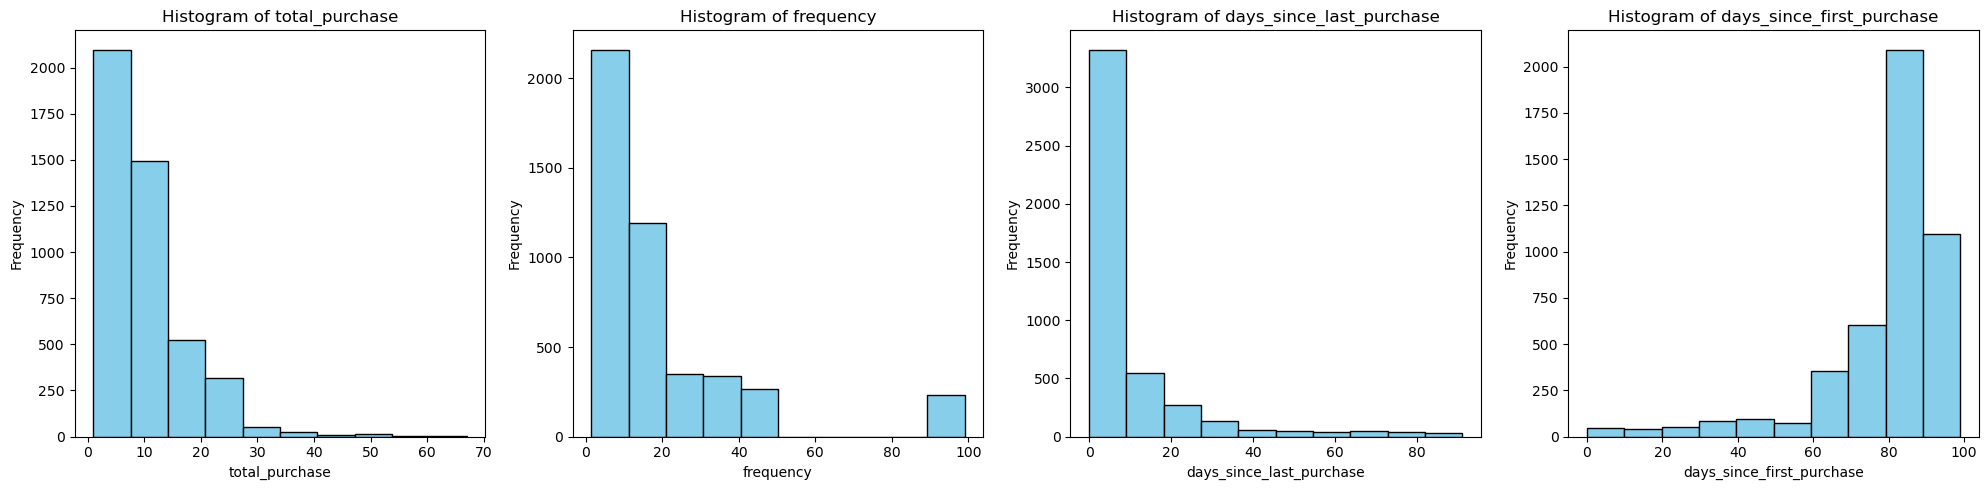

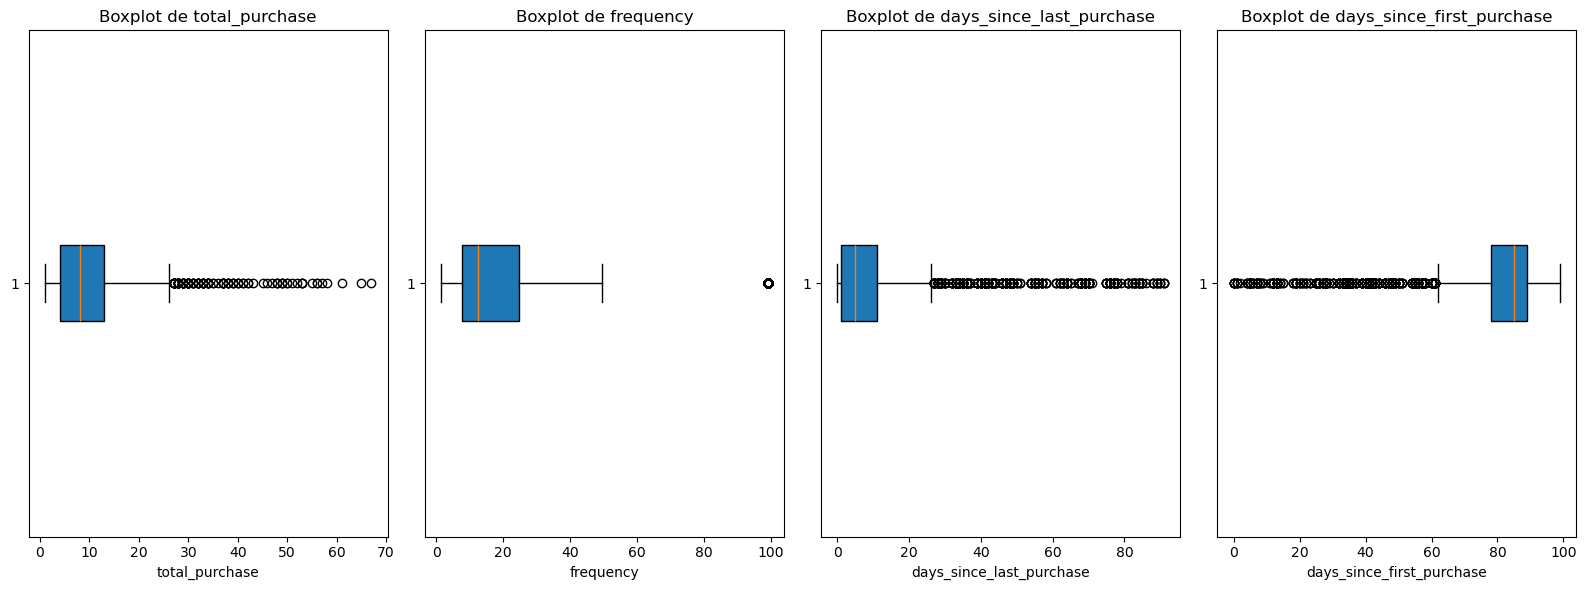

In [54]:
print(calculate_statistics(client_metrics, ['total_purchase','frequency','days_since_last_purchase','days_since_first_purchase']))
plot_histograms(client_metrics, ['total_purchase','frequency',"days_since_last_purchase", "days_since_first_purchase"])
plot_boxplots(client_metrics, ['total_purchase','frequency',"days_since_last_purchase", "days_since_first_purchase"])

#### **Sobre los items**

* ¿Cuál es la cantidad total de items disponibles para recomendación?

* ¿Cuál es el ratio de items por cliente?

* ¿Cuál es la cantidad de items promedio que cada cliente compra?

In [55]:
transactions.head()

,account_id,sku_id,invoice_date,order_id,items_phys_cases
i64,str,str,date,str,i64
0,"""430606""","""7038""",2022-07-29,"""512-3880249-0""",100
1,"""323267""","""14933""",2022-07-29,"""512-3882307-0""",1
2,"""357825""","""21971""",2022-07-23,"""512-3852880-0""",8
3,"""444926""","""7038""",2022-08-05,"""512-3913163-0""",20
4,"""450771""","""7030""",2022-08-16,"""512-3957000-0""",5


#### **Análisis de cohorte sobre las transacciones**
    
* ¿Cómo se comportan las diferentes cohortes de clientes a lo largo del tiempo?
    
* ¿Cómo evolucionan las ventas en diferentes cohortes?